## Import packages

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet18
from torch import nn
import pytorch_lightning as pl

import ast
from pathlib import Path
import pandas as pd
import numpy as np
import wandb
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
print(f'torch=={torch.__version__}')
print(f'wandb=={wandb.__version__}')
print(f'pytorch_lightning=={pl.__version__}')

torch==1.12.1+cu102
wandb==0.13.4
pytorch_lightning==1.7.7


## Necessary paths

In [3]:
project_path = Path.cwd().parent
mri_dir = project_path/'data/processed/mri'
csv_dir = project_path/'data/processed/csv'

## Hyperparams

In [4]:
train_batch_size = 200
val_batch_size = 10
learning_rate = 1e-3

## Make the train and test Dataset and DataLoader

In [5]:
class MRIDataset(Dataset):

    def __init__(self, mri_dir: Path, mode='train') -> None:
        if mode == 'train':
            self.data_dir = mri_dir/'train'
            self.df = pd.read_csv(csv_dir/'train_mri_patients.csv')
        elif mode == 'val':
            self.data_dir = mri_dir/'val'
            self.df = pd.read_csv(csv_dir/'val_mri_patients.csv')
        else:
            raise ValueError('mode should be train, test or val.')
        
        self.mode = mode
        self.mri_png_paths = list(self.data_dir.glob('*.png'))  # list of mri slices as png images
        self.img_size = 128

    def __getitem__(self, idx):
        """
        Return torch Tensor of an MRI slice and its label
        """
        png_path = self.mri_png_paths[idx]        
        data = read_image(str(png_path))
        data = data.type(torch.FloatTensor) 
        data = transforms.Resize((self.img_size, self.img_size))(data)
        patient_id = png_path.name.split('_')[0]
        label = self.df[self.df['patient']==patient_id]['label'].values[0]
        label = ast.literal_eval(label)
        label = torch.Tensor(label)

        return data, label

    def __len__(self):
        return len(self.mri_png_paths)

Train Dataset

input =  torch.Size([1, 128, 128]) --- label =  tensor([1., 1., 0., 0., 0.])
length of train_dataset = 20470


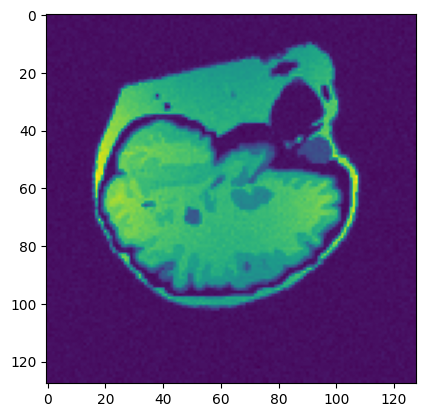

In [6]:
train_dataset = MRIDataset(mri_dir, 'train')
img, label = train_dataset[0]
print('input = ', img.shape, '--- label = ', label)
plt.imshow(img[0])
print(f'length of train_dataset = {len(train_dataset)}')

Val Dataset

torch.Size([1, 128, 128]) --- label =  tensor([0., 0., 0., 0., 0.])
length of train_dataset = 7130


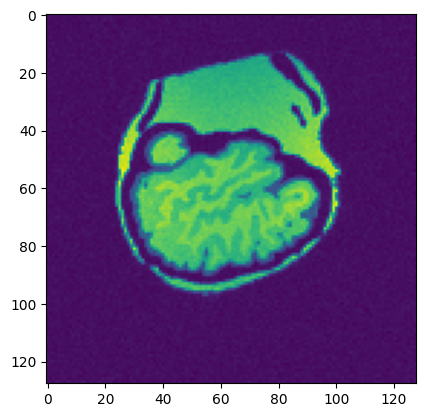

In [7]:
val_dataset = MRIDataset(mri_dir, 'val')
img, label = val_dataset[0]
print(img.shape, '--- label = ', label)
plt.imshow(img[0])
print(f'length of train_dataset = {len(val_dataset)}')

Train and Val Loaders

In [8]:
train_loader = DataLoader(train_dataset, 
                          batch_size=train_batch_size, 
                          shuffle=True, # images are loaded in random order
                          num_workers=12
                         )
                                                
val_loader = DataLoader(val_dataset, 
                        batch_size=val_batch_size,
                        num_workers=12
                        )

In [9]:
for i, batch in enumerate(train_loader):
    images, labels = batch
    print(images.shape, '---', labels.shape)
    break

torch.Size([200, 1, 128, 128]) --- torch.Size([200, 5])


## MRI Model

We build our model based on the `resnet18` model, which looks like below

In [10]:
rnet = resnet18()
rnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Building our model

In [11]:
class MRIModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.resnet = resnet18()
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7),  # change input channel to be 1 instead of 3 
                                      stride=(2, 2), padding=(3, 3), bias=False)
        # add a linear layer at the end for transfer learning
        self.linear = nn.Linear(in_features=self.resnet.fc.out_features,
                                out_features=5)

    # optionally, define a forward method
    def forward(self, xs):
        y_hats = self.resnet(xs)
        y_hats = self.linear(y_hats)
        return y_hats  # we like to just call the model's forward method
    
    def training_step(self, batch, batch_idx):
        xs, ys = batch
        y_hats = self.forward(xs)
        loss = F.binary_cross_entropy_with_logits(y_hats, ys)
        self.log("train_loss", loss)
        print(f'train_loss = {loss}')
        return loss

    def validation_step(self, batch, batch_idx):
        xs, ys = batch
        y_hats = self.forward(xs)
        loss = F.binary_cross_entropy_with_logits(y_hats, ys)
        self.log("val_loss", loss)
        print(f'val_loss = {loss}')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer


In [12]:
model = MRIModel()
trainer = pl.Trainer(accelerator='gpu', devices=int(torch.cuda.is_available()), max_epochs=100)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.7 M
1 | linear | Linear | 5.0 K 
----------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.753    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val_loss = 19.75227928161621
val_loss = 19.81938362121582


Training: 0it [00:00, ?it/s]

train_loss = 0.683600664138794
train_loss = 0.5192334055900574
train_loss = 0.5044604539871216
train_loss = 0.5667208433151245
train_loss = 0.5005658864974976
train_loss = 0.49273553490638733
train_loss = 0.4500163793563843
train_loss = 0.4821488857269287
train_loss = 0.4215458333492279
train_loss = 0.47420749068260193
train_loss = 0.44270655512809753
train_loss = 0.41895556449890137
train_loss = 0.4348496198654175
train_loss = 0.442502498626709
train_loss = 0.40011873841285706
train_loss = 0.4167660176753998
train_loss = 0.3939564526081085
train_loss = 0.3986833691596985
train_loss = 0.4377515912055969
train_loss = 0.4268302321434021
train_loss = 0.41957882046699524
train_loss = 0.42885372042655945
train_loss = 0.4087323248386383
train_loss = 0.4047117531299591
train_loss = 0.41378021240234375
train_loss = 0.4001474678516388
train_loss = 0.40051111578941345
train_loss = 0.4280431866645813
train_loss = 0.41026851534843445
train_loss = 0.4174118936061859
train_loss = 0.43684035539627075

Validation: 0it [00:00, ?it/s]

val_loss = 0.8505454659461975
val_loss = 0.8144364953041077
val_loss = 0.670879065990448
val_loss = 0.6839233040809631
val_loss = 0.8971346020698547
val_loss = 0.41273337602615356
val_loss = 0.4835759699344635
val_loss = 0.4460812211036682
val_loss = 0.4091856777667999
val_loss = 0.6279916167259216
val_loss = 0.7008945941925049
val_loss = 0.5583710074424744
val_loss = 0.5379687547683716
val_loss = 0.49950629472732544
val_loss = 0.7952225804328918
val_loss = 0.6221414804458618
val_loss = 0.805061399936676
val_loss = 0.42696142196655273
val_loss = 0.7672143578529358
val_loss = 0.6640154719352722
val_loss = 0.5470327138900757
val_loss = 0.4449034035205841
val_loss = 0.6554739475250244
val_loss = 0.38485845923423767
val_loss = 0.884382963180542
val_loss = 0.4262535870075226
val_loss = 0.5834812521934509
val_loss = 0.8253277540206909
val_loss = 0.9168279767036438
val_loss = 0.7129095196723938
val_loss = 0.8447201251983643
val_loss = 0.8164591789245605
val_loss = 0.5159544944763184
val_loss 

Validation: 0it [00:00, ?it/s]

val_loss = 2.0433380603790283
val_loss = 2.1096723079681396
val_loss = 1.6838696002960205
val_loss = 1.693150281906128
val_loss = 2.445558786392212
val_loss = 1.0279799699783325
val_loss = 1.1515605449676514
val_loss = 0.958153486251831
val_loss = 0.9504765272140503
val_loss = 1.388825535774231
val_loss = 1.783875823020935
val_loss = 1.3849996328353882
val_loss = 1.258800745010376
val_loss = 1.2548308372497559
val_loss = 2.130831480026245
val_loss = 1.6858406066894531
val_loss = 2.1835927963256836
val_loss = 1.0553730726242065
val_loss = 1.8842878341674805
val_loss = 1.7239733934402466
val_loss = 1.476880431175232
val_loss = 1.0740952491760254
val_loss = 1.7766988277435303
val_loss = 0.9473766684532166
val_loss = 2.1869008541107178
val_loss = 1.0166319608688354
val_loss = 1.430120825767517
val_loss = 2.036194324493408
val_loss = 2.35709547996521
val_loss = 1.9545389413833618
val_loss = 2.2965285778045654
val_loss = 2.2124321460723877
val_loss = 1.217674732208252
val_loss = 0.9790626168

Validation: 0it [00:00, ?it/s]

val_loss = 0.618025541305542
val_loss = 0.6278613805770874
val_loss = 0.5160996913909912
val_loss = 0.45351171493530273
val_loss = 0.40377840399742126
val_loss = 0.3618539273738861
val_loss = 0.38573524355888367
val_loss = 0.6101987361907959
val_loss = 0.3104427754878998
val_loss = 0.4296407699584961
val_loss = 0.448454886674881
val_loss = 0.6247680187225342
val_loss = 0.5247865319252014
val_loss = 0.32912588119506836
val_loss = 0.4146627187728882
val_loss = 0.2777503430843353
val_loss = 0.32941100001335144
val_loss = 0.4758099317550659
val_loss = 0.5348697304725647
val_loss = 0.2959422767162323
val_loss = 0.34220197796821594
val_loss = 0.2739941477775574
val_loss = 0.36969348788261414
val_loss = 0.319309264421463
val_loss = 0.691213846206665
val_loss = 0.3329332172870636
val_loss = 0.4922485947608948
val_loss = 0.6200054287910461
val_loss = 0.8295577764511108
val_loss = 0.44544103741645813
val_loss = 0.4872957766056061
val_loss = 0.4763023257255554
val_loss = 0.5404033064842224
val_lo

Validation: 0it [00:00, ?it/s]

val_loss = 1.0007357597351074
val_loss = 1.0929456949234009
val_loss = 0.9258257746696472
val_loss = 0.9966180920600891
val_loss = 1.1107251644134521
val_loss = 0.7924394011497498
val_loss = 0.8005654811859131
val_loss = 0.8854529857635498
val_loss = 0.4523636996746063
val_loss = 0.6692079901695251
val_loss = 0.8029547929763794
val_loss = 1.02617347240448
val_loss = 1.0522459745407104
val_loss = 0.4054970443248749
val_loss = 1.1369695663452148
val_loss = 0.9452757239341736
val_loss = 0.9845536351203918
val_loss = 0.7816517353057861
val_loss = 0.9675795435905457
val_loss = 0.7227538824081421
val_loss = 0.78609299659729
val_loss = 0.4959680438041687
val_loss = 0.6923280358314514
val_loss = 0.4348345994949341
val_loss = 1.615736961364746
val_loss = 0.5916898846626282
val_loss = 0.7130758762359619
val_loss = 1.238058090209961
val_loss = 1.7416437864303589
val_loss = 0.90931236743927
val_loss = 1.2907214164733887
val_loss = 0.9388602375984192
val_loss = 0.8160354495048523
val_loss = 0.64441

Validation: 0it [00:00, ?it/s]

val_loss = 1.1503280401229858
val_loss = 1.0134010314941406
val_loss = 1.0408936738967896
val_loss = 0.7300677299499512
val_loss = 0.8814312815666199
val_loss = 0.6256393194198608
val_loss = 0.8810250163078308
val_loss = 1.1361955404281616
val_loss = 0.552946925163269
val_loss = 0.8397170901298523
val_loss = 0.95586097240448
val_loss = 1.4624981880187988
val_loss = 1.033152461051941
val_loss = 0.8611384630203247
val_loss = 0.8217860460281372
val_loss = 0.6214876174926758
val_loss = 0.9997556209564209
val_loss = 0.9163438081741333
val_loss = 0.8728464841842651
val_loss = 0.825641930103302
val_loss = 0.9355573058128357
val_loss = 0.8263331651687622
val_loss = 0.8563637137413025
val_loss = 0.7410608530044556
val_loss = 1.26372492313385
val_loss = 0.6843116879463196
val_loss = 0.911108672618866
val_loss = 0.8489617109298706
val_loss = 1.363732099533081
val_loss = 0.9705612063407898
val_loss = 1.211228609085083
val_loss = 1.0308197736740112
val_loss = 1.306944727897644
val_loss = 0.94677215

Validation: 0it [00:00, ?it/s]

val_loss = 1.7270312309265137
val_loss = 1.632445216178894
val_loss = 1.5146540403366089
val_loss = 1.3983722925186157
val_loss = 1.2998201847076416
val_loss = 0.8557072281837463
val_loss = 1.1291120052337646
val_loss = 0.81707763671875
val_loss = 0.6947998404502869
val_loss = 0.9191694259643555
val_loss = 1.355893850326538
val_loss = 1.1267471313476562
val_loss = 0.8598374724388123
val_loss = 0.6932780146598816
val_loss = 0.916420578956604
val_loss = 0.7706738114356995
val_loss = 1.2830806970596313
val_loss = 0.7936353087425232
val_loss = 1.333761215209961
val_loss = 0.7265304327011108
val_loss = 0.7212157845497131
val_loss = 0.7262603044509888
val_loss = 0.6125066876411438
val_loss = 0.848168134689331
val_loss = 1.89836847782135
val_loss = 0.8266319632530212
val_loss = 1.3779799938201904
val_loss = 1.4492181539535522
val_loss = 0.8205369114875793
val_loss = 1.2133924961090088
val_loss = 1.2694194316864014
val_loss = 1.0880483388900757
val_loss = 1.161919116973877
val_loss = 0.6628060

Validation: 0it [00:00, ?it/s]

val_loss = 1.4078158140182495
val_loss = 1.4399769306182861
val_loss = 1.6239430904388428
val_loss = 1.2916512489318848
val_loss = 1.3195364475250244
val_loss = 0.7910541892051697
val_loss = 1.4181673526763916
val_loss = 1.279855728149414
val_loss = 0.4350522458553314
val_loss = 1.3288720846176147
val_loss = 1.3698028326034546
val_loss = 1.7676998376846313
val_loss = 1.5111761093139648
val_loss = 0.8651161789894104
val_loss = 1.3056610822677612
val_loss = 0.7546929717063904
val_loss = 1.4479429721832275
val_loss = 1.0764254331588745
val_loss = 1.483300805091858
val_loss = 1.4998432397842407
val_loss = 1.1086305379867554
val_loss = 0.9590920805931091
val_loss = 1.051832914352417
val_loss = 1.065535306930542
val_loss = 1.2567405700683594
val_loss = 1.006007194519043
val_loss = 1.2392524480819702
val_loss = 2.072671413421631
val_loss = 1.315944790840149
val_loss = 1.108298659324646
val_loss = 1.7708216905593872
val_loss = 1.541686773300171
val_loss = 1.4394654035568237
val_loss = 1.136791

Validation: 0it [00:00, ?it/s]

val_loss = 1.727543592453003
val_loss = 2.141087055206299
val_loss = 1.544320821762085
val_loss = 1.2990856170654297
val_loss = 2.047208309173584
val_loss = 1.0914627313613892
val_loss = 2.039574146270752
val_loss = 1.5766873359680176
val_loss = 0.7872408628463745
val_loss = 1.275194525718689
val_loss = 1.3790154457092285
val_loss = 1.7689094543457031
val_loss = 1.4929016828536987
val_loss = 0.8676820397377014
val_loss = 1.4702554941177368
val_loss = 1.380761981010437
val_loss = 1.5261728763580322
val_loss = 0.7057351469993591
val_loss = 1.4328149557113647
val_loss = 0.9119306206703186
val_loss = 0.849750816822052
val_loss = 0.9522321224212646
val_loss = 1.0292892456054688
val_loss = 1.3598411083221436
val_loss = 2.2657809257507324
val_loss = 1.0495935678482056
val_loss = 1.618395447731018
val_loss = 1.1393579244613647
val_loss = 1.9312580823898315
val_loss = 1.1060816049575806
val_loss = 1.8221018314361572
val_loss = 1.7639843225479126
val_loss = 1.6648508310317993
val_loss = 1.456836

Validation: 0it [00:00, ?it/s]

val_loss = 1.478733777999878
val_loss = 1.7934398651123047
val_loss = 0.7662349343299866
val_loss = 1.4613037109375
val_loss = 1.3186700344085693
val_loss = 1.2443385124206543
val_loss = 1.9044382572174072
val_loss = 1.2125284671783447
val_loss = 0.5872306823730469
val_loss = 1.4876372814178467
val_loss = 1.412398338317871
val_loss = 0.9557991027832031
val_loss = 1.2135396003723145
val_loss = 0.8395856022834778
val_loss = 1.143144965171814
val_loss = 0.9286637902259827
val_loss = 1.3055741786956787
val_loss = 0.8901495337486267
val_loss = 1.2349646091461182
val_loss = 0.5949556231498718
val_loss = 0.7203359603881836
val_loss = 0.22876715660095215
val_loss = 1.3209377527236938
val_loss = 1.1659914255142212
val_loss = 2.5363099575042725
val_loss = 0.7359260320663452
val_loss = 1.5498064756393433
val_loss = 1.4504023790359497
val_loss = 1.7919987440109253
val_loss = 0.8839201331138611
val_loss = 1.1655306816101074
val_loss = 1.5718427896499634
val_loss = 1.9139140844345093
val_loss = 1.05

Validation: 0it [00:00, ?it/s]

val_loss = 1.6023657321929932
val_loss = 1.1554858684539795
val_loss = 0.9589002728462219
val_loss = 1.8021788597106934
val_loss = 1.2747293710708618
val_loss = 1.198315978050232
val_loss = 1.7094707489013672
val_loss = 1.2873613834381104
val_loss = 0.6270725727081299
val_loss = 1.3657901287078857
val_loss = 0.9882868528366089
val_loss = 1.066591501235962
val_loss = 1.7457009553909302
val_loss = 0.7227293848991394
val_loss = 1.4236880540847778
val_loss = 1.5571198463439941
val_loss = 0.9143330454826355
val_loss = 0.9961249828338623
val_loss = 1.1313180923461914
val_loss = 0.8898270726203918
val_loss = 1.1304378509521484
val_loss = 0.7594660520553589
val_loss = 0.5105662941932678
val_loss = 1.3146427869796753
val_loss = 2.862088441848755
val_loss = 0.5577062368392944
val_loss = 1.3907421827316284
val_loss = 2.0825395584106445
val_loss = 2.232004404067993
val_loss = 1.0625402927398682
val_loss = 1.9144772291183472
val_loss = 1.8639484643936157
val_loss = 0.846660852432251
val_loss = 1.05

Validation: 0it [00:00, ?it/s]

val_loss = 1.279339075088501
val_loss = 2.0310187339782715
val_loss = 0.6850570440292358
val_loss = 1.4036450386047363
val_loss = 1.5108498334884644
val_loss = 0.928453266620636
val_loss = 1.2615675926208496
val_loss = 1.5158365964889526
val_loss = 0.5601229667663574
val_loss = 1.4305384159088135
val_loss = 1.0089857578277588
val_loss = 1.1751925945281982
val_loss = 1.1002362966537476
val_loss = 0.8248856663703918
val_loss = 1.372627854347229
val_loss = 0.8354820609092712
val_loss = 0.5329927802085876
val_loss = 0.7177598476409912
val_loss = 1.2182676792144775
val_loss = 0.3172800540924072
val_loss = 0.6492974758148193
val_loss = 0.3365308344364166
val_loss = 1.107613444328308
val_loss = 1.5109323263168335
val_loss = 2.270440101623535
val_loss = 0.5230961441993713
val_loss = 1.1043531894683838
val_loss = 1.249867558479309
val_loss = 1.9243438243865967
val_loss = 1.3407257795333862
val_loss = 1.3292129039764404
val_loss = 1.8270174264907837
val_loss = 1.4189900159835815
val_loss = 0.951

Validation: 0it [00:00, ?it/s]

val_loss = 2.688138484954834
val_loss = 1.6290667057037354
val_loss = 0.9066500067710876
val_loss = 1.8973073959350586
val_loss = 2.173370122909546
val_loss = 2.7708165645599365
val_loss = 2.9908220767974854
val_loss = 2.00380277633667
val_loss = 1.5191034078598022
val_loss = 2.1450932025909424
val_loss = 1.6199010610580444
val_loss = 1.7666577100753784
val_loss = 2.0529069900512695
val_loss = 1.6694315671920776
val_loss = 2.8911590576171875
val_loss = 2.9347777366638184
val_loss = 1.691650152206421
val_loss = 1.1296851634979248
val_loss = 1.852327585220337
val_loss = 2.2431013584136963
val_loss = 1.0605722665786743
val_loss = 1.4092767238616943
val_loss = 1.2144019603729248
val_loss = 1.7162606716156006
val_loss = 3.6074609756469727
val_loss = 0.7683348059654236
val_loss = 1.6771479845046997
val_loss = 2.9897189140319824
val_loss = 4.1717529296875
val_loss = 1.7698142528533936
val_loss = 3.5408589839935303
val_loss = 2.3227319717407227
val_loss = 1.8204519748687744
val_loss = 1.520830

Validation: 0it [00:00, ?it/s]

val_loss = 1.8163708448410034
val_loss = 2.194242238998413
val_loss = 1.3819501399993896
val_loss = 2.145718812942505
val_loss = 1.869997501373291
val_loss = 1.4164788722991943
val_loss = 1.988580584526062
val_loss = 2.4760568141937256
val_loss = 0.8048755526542664
val_loss = 1.687225341796875
val_loss = 1.5994192361831665
val_loss = 2.3802106380462646
val_loss = 1.9718328714370728
val_loss = 1.3532445430755615
val_loss = 1.3254270553588867
val_loss = 0.8521477580070496
val_loss = 1.4568822383880615
val_loss = 0.6100664734840393
val_loss = 2.0722527503967285
val_loss = 1.0459595918655396
val_loss = 0.5579115748405457
val_loss = 0.9177873134613037
val_loss = 1.3272347450256348
val_loss = 2.0785000324249268
val_loss = 2.713735818862915
val_loss = 0.8111993074417114
val_loss = 1.8564984798431396
val_loss = 1.7679684162139893
val_loss = 2.212543487548828
val_loss = 1.3001971244812012
val_loss = 1.209127426147461
val_loss = 1.9870848655700684
val_loss = 2.2416775226593018
val_loss = 1.34508

Validation: 0it [00:00, ?it/s]

val_loss = 4.451216220855713
val_loss = 3.11842942237854
val_loss = 3.035691976547241
val_loss = 3.4735217094421387
val_loss = 5.786964416503906
val_loss = 3.684971332550049
val_loss = 4.310187339782715
val_loss = 2.8536794185638428
val_loss = 2.247218608856201
val_loss = 4.372351169586182
val_loss = 4.25697135925293
val_loss = 2.72548770904541
val_loss = 3.6886162757873535
val_loss = 2.1143999099731445
val_loss = 5.223078727722168
val_loss = 4.438843727111816
val_loss = 3.070013999938965
val_loss = 2.705279588699341
val_loss = 3.211866617202759
val_loss = 3.3732292652130127
val_loss = 3.2242629528045654
val_loss = 1.8872501850128174
val_loss = 2.920710325241089
val_loss = 2.3039932250976562
val_loss = 6.876646518707275
val_loss = 1.6455764770507812
val_loss = 4.046582221984863
val_loss = 5.864938259124756
val_loss = 7.679139137268066
val_loss = 2.86820125579834
val_loss = 7.255513668060303
val_loss = 3.928309202194214
val_loss = 4.075138568878174
val_loss = 3.5384905338287354
val_loss

Validation: 0it [00:00, ?it/s]

val_loss = 1.7695105075836182
val_loss = 1.8864569664001465
val_loss = 1.0792343616485596
val_loss = 2.2489726543426514
val_loss = 2.10577392578125
val_loss = 2.188905954360962
val_loss = 2.694305896759033
val_loss = 2.2071330547332764
val_loss = 0.7615902423858643
val_loss = 1.9178193807601929
val_loss = 1.942097544670105
val_loss = 1.6775590181350708
val_loss = 1.5290791988372803
val_loss = 1.0600734949111938
val_loss = 2.9887537956237793
val_loss = 2.372851848602295
val_loss = 1.059550404548645
val_loss = 1.4887973070144653
val_loss = 1.3810622692108154
val_loss = 1.9472713470458984
val_loss = 1.1836575269699097
val_loss = 0.8128313422203064
val_loss = 0.89812833070755
val_loss = 1.7835445404052734
val_loss = 3.05181622505188
val_loss = 0.878576934337616
val_loss = 0.8933348655700684
val_loss = 2.970078706741333
val_loss = 3.272554874420166
val_loss = 1.60777747631073
val_loss = 2.6438210010528564
val_loss = 2.84098744392395
val_loss = 1.1459380388259888
val_loss = 1.576623201370239

Validation: 0it [00:00, ?it/s]

val_loss = 1.7828218936920166
val_loss = 2.6335830688476562
val_loss = 1.080366849899292
val_loss = 1.76309335231781
val_loss = 1.073285460472107
val_loss = 1.4803121089935303
val_loss = 1.4071513414382935
val_loss = 2.482846260070801
val_loss = 0.7991830110549927
val_loss = 1.942076325416565
val_loss = 1.2733434438705444
val_loss = 1.6499764919281006
val_loss = 1.8430782556533813
val_loss = 1.3586230278015137
val_loss = 1.503655195236206
val_loss = 0.9303867816925049
val_loss = 1.0312573909759521
val_loss = 0.6979648470878601
val_loss = 2.1519792079925537
val_loss = 1.0377265214920044
val_loss = 0.9382480382919312
val_loss = 0.9562879800796509
val_loss = 0.9878495335578918
val_loss = 1.8615243434906006
val_loss = 2.7741408348083496
val_loss = 0.7277500629425049
val_loss = 1.6462963819503784
val_loss = 2.1318376064300537
val_loss = 2.4195713996887207
val_loss = 1.6191372871398926
val_loss = 1.2190074920654297
val_loss = 1.8202149868011475
val_loss = 1.8616766929626465
val_loss = 1.2973

Validation: 0it [00:00, ?it/s]

val_loss = 3.8134565353393555
val_loss = 3.2275450229644775
val_loss = 2.3288536071777344
val_loss = 3.829936981201172
val_loss = 5.651735782623291
val_loss = 4.283543109893799
val_loss = 5.352985858917236
val_loss = 2.6069276332855225
val_loss = 1.7471964359283447
val_loss = 4.003238677978516
val_loss = 4.04231595993042
val_loss = 3.171508312225342
val_loss = 3.8118772506713867
val_loss = 2.212263345718384
val_loss = 5.657919883728027
val_loss = 4.787952899932861
val_loss = 3.7472431659698486
val_loss = 2.85983943939209
val_loss = 3.0916290283203125
val_loss = 3.867234945297241
val_loss = 3.0888848304748535
val_loss = 2.1360232830047607
val_loss = 3.2664499282836914
val_loss = 2.7759125232696533
val_loss = 5.267765998840332
val_loss = 1.9565461874008179
val_loss = 2.6344103813171387
val_loss = 5.814406394958496
val_loss = 7.219310283660889
val_loss = 3.0416359901428223
val_loss = 7.733902454376221
val_loss = 5.136897087097168
val_loss = 3.3238933086395264
val_loss = 3.511680841445923


Validation: 0it [00:00, ?it/s]

val_loss = 2.3621981143951416
val_loss = 1.9305864572525024
val_loss = 1.0071372985839844
val_loss = 1.4416130781173706
val_loss = 0.9873685240745544
val_loss = 1.976851463317871
val_loss = 2.3346099853515625
val_loss = 2.2946088314056396
val_loss = 1.3717422485351562
val_loss = 1.626695156097412
val_loss = 1.3767669200897217
val_loss = 1.9976204633712769
val_loss = 1.9524692296981812
val_loss = 1.2865493297576904
val_loss = 1.3555080890655518
val_loss = 1.533433198928833
val_loss = 1.2635140419006348
val_loss = 0.6468546390533447
val_loss = 1.4869167804718018
val_loss = 1.8227418661117554
val_loss = 0.9541552662849426
val_loss = 1.239418387413025
val_loss = 1.0866641998291016
val_loss = 1.3389252424240112
val_loss = 3.8244307041168213
val_loss = 0.571601927280426
val_loss = 1.3995074033737183
val_loss = 2.974761962890625
val_loss = 4.481123447418213
val_loss = 1.2041298151016235
val_loss = 1.9025068283081055
val_loss = 1.9509943723678589
val_loss = 1.8840596675872803
val_loss = 1.2880

Validation: 0it [00:00, ?it/s]

val_loss = 1.8069475889205933
val_loss = 2.6234021186828613
val_loss = 1.1352107524871826
val_loss = 2.0925848484039307
val_loss = 2.1620066165924072
val_loss = 1.8323523998260498
val_loss = 2.210292100906372
val_loss = 2.0202407836914062
val_loss = 0.8955084085464478
val_loss = 1.7656404972076416
val_loss = 1.0363719463348389
val_loss = 2.0869669914245605
val_loss = 1.937551498413086
val_loss = 1.3974189758300781
val_loss = 2.8692946434020996
val_loss = 1.951527714729309
val_loss = 0.7135746479034424
val_loss = 1.1249366998672485
val_loss = 1.320365071296692
val_loss = 0.9510940909385681
val_loss = 1.271594524383545
val_loss = 0.9194365739822388
val_loss = 1.4385600090026855
val_loss = 1.6325603723526
val_loss = 4.289847373962402
val_loss = 1.0855005979537964
val_loss = 0.8892967104911804
val_loss = 2.13421630859375
val_loss = 3.8753960132598877
val_loss = 1.8320412635803223
val_loss = 1.9807647466659546
val_loss = 3.039182662963867
val_loss = 1.6372489929199219
val_loss = 1.242946505

Validation: 0it [00:00, ?it/s]

val_loss = 1.8070610761642456
val_loss = 2.315626621246338
val_loss = 0.9853073954582214
val_loss = 2.06846022605896
val_loss = 1.5663291215896606
val_loss = 1.632524847984314
val_loss = 1.8096548318862915
val_loss = 2.6290283203125
val_loss = 1.0271042585372925
val_loss = 2.5893988609313965
val_loss = 1.262510895729065
val_loss = 1.8470031023025513
val_loss = 1.9520922899246216
val_loss = 1.6312223672866821
val_loss = 1.545947551727295
val_loss = 1.170777678489685
val_loss = 1.0984599590301514
val_loss = 0.4966748058795929
val_loss = 2.602576494216919
val_loss = 1.3533931970596313
val_loss = 0.7319777011871338
val_loss = 1.058274507522583
val_loss = 1.117201328277588
val_loss = 2.014848470687866
val_loss = 2.847010850906372
val_loss = 1.3090918064117432
val_loss = 1.6112382411956787
val_loss = 2.0175974369049072
val_loss = 2.416456460952759
val_loss = 1.8156826496124268
val_loss = 1.6842129230499268
val_loss = 2.107403516769409
val_loss = 1.948546290397644
val_loss = 1.583368897438049

Validation: 0it [00:00, ?it/s]

val_loss = 2.168909788131714
val_loss = 2.716168165206909
val_loss = 1.0264363288879395
val_loss = 3.173330545425415
val_loss = 1.794331669807434
val_loss = 1.5274513959884644
val_loss = 1.680767297744751
val_loss = 2.6184751987457275
val_loss = 1.2049905061721802
val_loss = 2.1962969303131104
val_loss = 1.6470931768417358
val_loss = 2.1383471488952637
val_loss = 2.4312474727630615
val_loss = 1.8047499656677246
val_loss = 1.0993146896362305
val_loss = 1.2618730068206787
val_loss = 1.4944435358047485
val_loss = 1.2400223016738892
val_loss = 2.6601481437683105
val_loss = 1.8319796323776245
val_loss = 0.9415291547775269
val_loss = 1.1778570413589478
val_loss = 1.2696410417556763
val_loss = 1.8937911987304688
val_loss = 3.1102519035339355
val_loss = 1.2220234870910645
val_loss = 1.9047225713729858
val_loss = 2.584291934967041
val_loss = 3.0026004314422607
val_loss = 2.5963387489318848
val_loss = 1.2992554903030396
val_loss = 1.9748636484146118
val_loss = 2.4548470973968506
val_loss = 1.433

Validation: 0it [00:00, ?it/s]

val_loss = 1.9472225904464722
val_loss = 3.0031826496124268
val_loss = 0.6299971342086792
val_loss = 1.9895261526107788
val_loss = 1.4346067905426025
val_loss = 1.9394499063491821
val_loss = 1.6678977012634277
val_loss = 2.2138655185699463
val_loss = 0.8831572532653809
val_loss = 2.1163198947906494
val_loss = 0.9428184032440186
val_loss = 2.0607235431671143
val_loss = 1.8262426853179932
val_loss = 1.6300709247589111
val_loss = 2.097378730773926
val_loss = 1.3512763977050781
val_loss = 1.247256875038147
val_loss = 1.0129042863845825
val_loss = 1.6912133693695068
val_loss = 0.8345267176628113
val_loss = 0.9745305180549622
val_loss = 0.47896936535835266
val_loss = 1.5305020809173584
val_loss = 2.2056405544281006
val_loss = 3.15994930267334
val_loss = 0.968116283416748
val_loss = 1.5625776052474976
val_loss = 2.102236270904541
val_loss = 2.5670852661132812
val_loss = 1.7010928392410278
val_loss = 1.418914794921875
val_loss = 2.4996798038482666
val_loss = 2.1270816326141357
val_loss = 1.246

Validation: 0it [00:00, ?it/s]

val_loss = 2.175220489501953
val_loss = 1.8845999240875244
val_loss = 1.0206127166748047
val_loss = 2.0628485679626465
val_loss = 2.0266683101654053
val_loss = 3.006232261657715
val_loss = 3.5571250915527344
val_loss = 1.6671712398529053
val_loss = 0.8107072114944458
val_loss = 2.336005926132202
val_loss = 2.0314955711364746
val_loss = 2.362783432006836
val_loss = 2.2565906047821045
val_loss = 1.4779057502746582
val_loss = 3.424194812774658
val_loss = 2.909207344055176
val_loss = 1.2353988885879517
val_loss = 2.022613286972046
val_loss = 1.5384337902069092
val_loss = 1.530131459236145
val_loss = 1.5346359014511108
val_loss = 0.9395200610160828
val_loss = 1.3586220741271973
val_loss = 2.5686888694763184
val_loss = 3.3238329887390137
val_loss = 0.5963987112045288
val_loss = 1.097063422203064
val_loss = 4.185285568237305
val_loss = 4.343395709991455
val_loss = 1.9465398788452148
val_loss = 3.81213116645813
val_loss = 3.4345574378967285
val_loss = 1.6624016761779785
val_loss = 1.3861418962

Validation: 0it [00:00, ?it/s]

val_loss = 2.0014190673828125
val_loss = 2.4753546714782715
val_loss = 0.9733333587646484
val_loss = 2.221003770828247
val_loss = 0.9493435621261597
val_loss = 1.4892059564590454
val_loss = 1.2839350700378418
val_loss = 3.30466365814209
val_loss = 1.180076241493225
val_loss = 2.329313039779663
val_loss = 1.6227830648422241
val_loss = 1.592670202255249
val_loss = 2.2399203777313232
val_loss = 1.3477118015289307
val_loss = 1.1348930597305298
val_loss = 1.480209469795227
val_loss = 1.0349171161651611
val_loss = 0.4813865125179291
val_loss = 2.302302598953247
val_loss = 1.5937390327453613
val_loss = 1.0727870464324951
val_loss = 1.137115716934204
val_loss = 1.4642667770385742
val_loss = 1.6827940940856934
val_loss = 2.9063847064971924
val_loss = 0.9828999042510986
val_loss = 1.635512351989746
val_loss = 2.5179033279418945
val_loss = 2.6928012371063232
val_loss = 2.068453311920166
val_loss = 1.7358856201171875
val_loss = 1.7813775539398193
val_loss = 2.1244008541107178
val_loss = 1.75989377

Validation: 0it [00:00, ?it/s]

val_loss = 2.223900556564331
val_loss = 2.261491537094116
val_loss = 1.0804461240768433
val_loss = 1.77749502658844
val_loss = 1.318485975265503
val_loss = 1.7312428951263428
val_loss = 1.7809300422668457
val_loss = 2.246602773666382
val_loss = 1.2442262172698975
val_loss = 1.7032265663146973
val_loss = 1.5484920740127563
val_loss = 2.0924665927886963
val_loss = 2.3472723960876465
val_loss = 1.4959427118301392
val_loss = 1.3407008647918701
val_loss = 1.5987986326217651
val_loss = 0.8100735545158386
val_loss = 1.2060047388076782
val_loss = 1.4334299564361572
val_loss = 1.057270884513855
val_loss = 1.1655278205871582
val_loss = 1.019815444946289
val_loss = 0.9697882533073425
val_loss = 1.7779788970947266
val_loss = 4.334761619567871
val_loss = 1.1986143589019775
val_loss = 1.5636706352233887
val_loss = 2.497661828994751
val_loss = 3.848627805709839
val_loss = 1.7538394927978516
val_loss = 1.7627166509628296
val_loss = 1.64530611038208
val_loss = 1.7613177299499512
val_loss = 1.2861508131

Validation: 0it [00:00, ?it/s]

val_loss = 2.045130968093872
val_loss = 2.4255118370056152
val_loss = 0.9276662468910217
val_loss = 2.309079647064209
val_loss = 1.6634167432785034
val_loss = 1.492220163345337
val_loss = 1.7147611379623413
val_loss = 2.643634080886841
val_loss = 1.0485258102416992
val_loss = 2.0092086791992188
val_loss = 1.556233525276184
val_loss = 1.9887133836746216
val_loss = 1.9033721685409546
val_loss = 1.8197280168533325
val_loss = 1.4168167114257812
val_loss = 1.38901948928833
val_loss = 1.4831997156143188
val_loss = 0.7487368583679199
val_loss = 2.627695322036743
val_loss = 1.6315888166427612
val_loss = 0.9221760630607605
val_loss = 1.0302529335021973
val_loss = 1.1968814134597778
val_loss = 1.6767395734786987
val_loss = 2.7890374660491943
val_loss = 1.8056424856185913
val_loss = 1.6718297004699707
val_loss = 2.960197925567627
val_loss = 2.5074145793914795
val_loss = 1.72292160987854
val_loss = 1.450240135192871
val_loss = 2.0022616386413574
val_loss = 1.5120822191238403
val_loss = 1.318980932

Validation: 0it [00:00, ?it/s]

val_loss = 3.1426074504852295
val_loss = 3.510802745819092
val_loss = 1.2828044891357422
val_loss = 2.591158390045166
val_loss = 1.2027088403701782
val_loss = 2.05717134475708
val_loss = 1.5988000631332397
val_loss = 3.4516375064849854
val_loss = 1.3568357229232788
val_loss = 2.453883409500122
val_loss = 1.4249187707901
val_loss = 1.7351478338241577
val_loss = 2.566365957260132
val_loss = 1.488629937171936
val_loss = 2.0089237689971924
val_loss = 1.5042895078659058
val_loss = 1.6224417686462402
val_loss = 0.5261777639389038
val_loss = 3.4516215324401855
val_loss = 2.4378411769866943
val_loss = 1.0888233184814453
val_loss = 1.3328388929367065
val_loss = 1.8965362310409546
val_loss = 2.337650775909424
val_loss = 1.9113802909851074
val_loss = 1.5923211574554443
val_loss = 2.9311282634735107
val_loss = 3.7217047214508057
val_loss = 2.518387794494629
val_loss = 2.463899850845337
val_loss = 2.667437791824341
val_loss = 1.9413875341415405
val_loss = 1.7986581325531006
val_loss = 1.24078524112

Validation: 0it [00:00, ?it/s]

val_loss = 2.2387709617614746
val_loss = 3.0625088214874268
val_loss = 0.830668032169342
val_loss = 2.1759185791015625
val_loss = 1.5591790676116943
val_loss = 1.2511601448059082
val_loss = 1.6445220708847046
val_loss = 2.5215981006622314
val_loss = 0.7933180332183838
val_loss = 2.1948349475860596
val_loss = 1.280652403831482
val_loss = 2.450313091278076
val_loss = 2.154927968978882
val_loss = 1.6223242282867432
val_loss = 1.86197030544281
val_loss = 1.397129774093628
val_loss = 0.8219625949859619
val_loss = 0.9680579900741577
val_loss = 1.5940825939178467
val_loss = 0.3809930682182312
val_loss = 0.8263834118843079
val_loss = 0.5803892016410828
val_loss = 1.1962066888809204
val_loss = 1.827185034751892
val_loss = 4.054259300231934
val_loss = 0.8473917841911316
val_loss = 1.6705132722854614
val_loss = 2.6096911430358887
val_loss = 3.665778636932373
val_loss = 1.8978195190429688
val_loss = 1.4828732013702393
val_loss = 2.213315963745117
val_loss = 2.199228048324585
val_loss = 1.438723564

Validation: 0it [00:00, ?it/s]

val_loss = 1.8447093963623047
val_loss = 2.277888774871826
val_loss = 1.0120550394058228
val_loss = 2.8824095726013184
val_loss = 1.1896064281463623
val_loss = 1.1897494792938232
val_loss = 1.5040160417556763
val_loss = 2.754364013671875
val_loss = 1.3030376434326172
val_loss = 1.7405821084976196
val_loss = 1.3489751815795898
val_loss = 2.014688730239868
val_loss = 2.7666563987731934
val_loss = 1.883870244026184
val_loss = 1.1310009956359863
val_loss = 1.7254853248596191
val_loss = 0.8416750431060791
val_loss = 1.1017719507217407
val_loss = 2.304304838180542
val_loss = 1.320670247077942
val_loss = 1.3230608701705933
val_loss = 1.1494237184524536
val_loss = 1.4724973440170288
val_loss = 1.3448373079299927
val_loss = 3.2411162853240967
val_loss = 1.2610371112823486
val_loss = 1.664639949798584
val_loss = 2.7075412273406982
val_loss = 3.0754971504211426
val_loss = 1.740365982055664
val_loss = 1.318441390991211
val_loss = 1.7331533432006836
val_loss = 1.990996241569519
val_loss = 1.2263805

Validation: 0it [00:00, ?it/s]

val_loss = 2.1006486415863037
val_loss = 2.9035050868988037
val_loss = 1.6004507541656494
val_loss = 2.193340539932251
val_loss = 2.035161018371582
val_loss = 1.9089215993881226
val_loss = 2.175173759460449
val_loss = 2.9022724628448486
val_loss = 1.3300772905349731
val_loss = 1.817724585533142
val_loss = 1.699790596961975
val_loss = 3.3326215744018555
val_loss = 2.220750331878662
val_loss = 1.9333986043930054
val_loss = 1.7652056217193604
val_loss = 1.4197520017623901
val_loss = 1.3229607343673706
val_loss = 0.9743337631225586
val_loss = 1.8178402185440063
val_loss = 1.0132108926773071
val_loss = 1.0916551351547241
val_loss = 1.1996337175369263
val_loss = 1.4544190168380737
val_loss = 2.159893274307251
val_loss = 3.851872444152832
val_loss = 1.0683029890060425
val_loss = 1.3345359563827515
val_loss = 1.9406239986419678
val_loss = 3.1462182998657227
val_loss = 1.1953160762786865
val_loss = 1.6268740892410278
val_loss = 2.1540043354034424
val_loss = 2.283831834793091
val_loss = 1.753417

Validation: 0it [00:00, ?it/s]

val_loss = 1.50786554813385
val_loss = 2.950822353363037
val_loss = 0.810364305973053
val_loss = 2.2112207412719727
val_loss = 1.6598366498947144
val_loss = 1.3468540906906128
val_loss = 2.240554094314575
val_loss = 2.4010672569274902
val_loss = 1.1354260444641113
val_loss = 2.2187440395355225
val_loss = 1.2024707794189453
val_loss = 1.9046601057052612
val_loss = 1.9361321926116943
val_loss = 1.5422062873840332
val_loss = 1.8721702098846436
val_loss = 1.8061449527740479
val_loss = 0.89296555519104
val_loss = 1.0493965148925781
val_loss = 1.4624905586242676
val_loss = 0.9108893871307373
val_loss = 0.7642703056335449
val_loss = 0.6154186129570007
val_loss = 1.5955538749694824
val_loss = 2.0646235942840576
val_loss = 4.6920881271362305
val_loss = 1.1777100563049316
val_loss = 1.2952171564102173
val_loss = 2.0957753658294678
val_loss = 3.646360397338867
val_loss = 1.690864086151123
val_loss = 1.4909613132476807
val_loss = 2.6827776432037354
val_loss = 1.515856385231018
val_loss = 1.5935659

Validation: 0it [00:00, ?it/s]

val_loss = 2.243046760559082
val_loss = 2.2102372646331787
val_loss = 0.5812805891036987
val_loss = 2.6606664657592773
val_loss = 1.4375115633010864
val_loss = 1.8332898616790771
val_loss = 1.5201047658920288
val_loss = 3.317922353744507
val_loss = 1.3169567584991455
val_loss = 1.9111942052841187
val_loss = 1.0713579654693604
val_loss = 2.2152810096740723
val_loss = 2.4833343029022217
val_loss = 1.893837809562683
val_loss = 1.484330415725708
val_loss = 1.9728002548217773
val_loss = 1.1822854280471802
val_loss = 0.6896935701370239
val_loss = 2.1845180988311768
val_loss = 0.8805278539657593
val_loss = 0.7709521055221558
val_loss = 0.810658872127533
val_loss = 1.5644909143447876
val_loss = 1.8150951862335205
val_loss = 3.5573418140411377
val_loss = 1.4879179000854492
val_loss = 1.9811556339263916
val_loss = 2.665909767150879
val_loss = 3.321688652038574
val_loss = 2.3731613159179688
val_loss = 1.5678226947784424
val_loss = 2.3444762229919434
val_loss = 2.1282660961151123
val_loss = 1.8520

Validation: 0it [00:00, ?it/s]

val_loss = 2.9789366722106934
val_loss = 2.768526792526245
val_loss = 1.1177756786346436
val_loss = 2.4419708251953125
val_loss = 2.3735857009887695
val_loss = 1.8474390506744385
val_loss = 2.3138580322265625
val_loss = 2.32515549659729
val_loss = 1.1580100059509277
val_loss = 1.7717359066009521
val_loss = 1.944191813468933
val_loss = 2.3771162033081055
val_loss = 2.0261476039886475
val_loss = 2.008064031600952
val_loss = 2.353100538253784
val_loss = 1.8096531629562378
val_loss = 1.4774601459503174
val_loss = 1.1265689134597778
val_loss = 1.4531258344650269
val_loss = 0.8595556616783142
val_loss = 0.5520692467689514
val_loss = 1.014321208000183
val_loss = 1.8444609642028809
val_loss = 2.193760871887207
val_loss = 4.363664627075195
val_loss = 0.9103405475616455
val_loss = 1.7612420320510864
val_loss = 2.5677313804626465
val_loss = 3.8355700969696045
val_loss = 2.081266164779663
val_loss = 2.1922342777252197
val_loss = 2.692639112472534
val_loss = 2.3301427364349365
val_loss = 1.30232810

Validation: 0it [00:00, ?it/s]

val_loss = 2.6614394187927246
val_loss = 2.8906500339508057
val_loss = 0.709054708480835
val_loss = 2.8793880939483643
val_loss = 2.618708372116089
val_loss = 2.0411417484283447
val_loss = 2.9326350688934326
val_loss = 3.0659563541412354
val_loss = 1.0840270519256592
val_loss = 2.0131125450134277
val_loss = 2.0231072902679443
val_loss = 2.1718029975891113
val_loss = 1.6936918497085571
val_loss = 1.7466720342636108
val_loss = 2.7658541202545166
val_loss = 2.5857412815093994
val_loss = 0.8187774419784546
val_loss = 0.9667364358901978
val_loss = 1.2071936130523682
val_loss = 0.8773765563964844
val_loss = 0.7613376975059509
val_loss = 1.3397659063339233
val_loss = 1.7339693307876587
val_loss = 2.6223244667053223
val_loss = 3.1863653659820557
val_loss = 1.0228489637374878
val_loss = 1.2637799978256226
val_loss = 2.3210344314575195
val_loss = 3.265955924987793
val_loss = 2.0317420959472656
val_loss = 2.0986568927764893
val_loss = 2.631166934967041
val_loss = 2.278726100921631
val_loss = 1.63

Validation: 0it [00:00, ?it/s]

val_loss = 2.3087098598480225
val_loss = 2.9335949420928955
val_loss = 0.7923567891120911
val_loss = 2.5111234188079834
val_loss = 1.9529927968978882
val_loss = 1.8271474838256836
val_loss = 2.1181039810180664
val_loss = 2.967088460922241
val_loss = 0.9663350582122803
val_loss = 2.3216216564178467
val_loss = 1.1432596445083618
val_loss = 2.698812246322632
val_loss = 1.9894109964370728
val_loss = 1.8542616367340088
val_loss = 1.893878698348999
val_loss = 1.7901840209960938
val_loss = 1.4932612180709839
val_loss = 0.3238016963005066
val_loss = 2.0730364322662354
val_loss = 0.8133297562599182
val_loss = 0.5653226971626282
val_loss = 0.743266224861145
val_loss = 1.469024896621704
val_loss = 2.1573712825775146
val_loss = 3.7806835174560547
val_loss = 0.8539544343948364
val_loss = 1.8211199045181274
val_loss = 2.090977191925049
val_loss = 3.162388801574707
val_loss = 1.8703320026397705
val_loss = 1.6003310680389404
val_loss = 2.370497703552246
val_loss = 2.7505412101745605
val_loss = 1.82752

Validation: 0it [00:00, ?it/s]

val_loss = 2.619509220123291
val_loss = 2.8927721977233887
val_loss = 0.5433656573295593
val_loss = 2.4288618564605713
val_loss = 2.5141139030456543
val_loss = 2.1776063442230225
val_loss = 2.764036178588867
val_loss = 2.9257616996765137
val_loss = 0.9297932386398315
val_loss = 1.6738802194595337
val_loss = 1.6324448585510254
val_loss = 2.0958495140075684
val_loss = 1.683030605316162
val_loss = 1.463978886604309
val_loss = 2.1094963550567627
val_loss = 2.3274471759796143
val_loss = 0.9719258546829224
val_loss = 1.0617022514343262
val_loss = 1.6837817430496216
val_loss = 1.2888915538787842
val_loss = 1.1459951400756836
val_loss = 1.2225316762924194
val_loss = 1.3646725416183472
val_loss = 2.2556066513061523
val_loss = 4.4207987785339355
val_loss = 1.1755030155181885
val_loss = 1.3345468044281006
val_loss = 3.0492820739746094
val_loss = 4.298670768737793
val_loss = 2.1582069396972656
val_loss = 2.1379103660583496
val_loss = 2.512887716293335
val_loss = 1.9651076793670654
val_loss = 1.481

Validation: 0it [00:00, ?it/s]

val_loss = 2.101059913635254
val_loss = 2.724898099899292
val_loss = 0.7529792785644531
val_loss = 1.8833850622177124
val_loss = 1.8664758205413818
val_loss = 2.195024013519287
val_loss = 2.0860724449157715
val_loss = 2.77651309967041
val_loss = 0.9391493201255798
val_loss = 1.820141077041626
val_loss = 1.0843393802642822
val_loss = 2.5235610008239746
val_loss = 2.5000765323638916
val_loss = 1.8200310468673706
val_loss = 1.6298503875732422
val_loss = 1.316551923751831
val_loss = 0.7418370842933655
val_loss = 0.8575352430343628
val_loss = 1.432473063468933
val_loss = 0.6796004176139832
val_loss = 1.200646162033081
val_loss = 0.9692887663841248
val_loss = 1.546424388885498
val_loss = 1.8130650520324707
val_loss = 3.9494645595550537
val_loss = 0.8979092240333557
val_loss = 1.2594757080078125
val_loss = 2.178632974624634
val_loss = 3.5622124671936035
val_loss = 1.7826119661331177
val_loss = 1.3473987579345703
val_loss = 2.323641300201416
val_loss = 2.993715524673462
val_loss = 1.2700141668

Validation: 0it [00:00, ?it/s]

val_loss = 2.4420669078826904
val_loss = 2.9115242958068848
val_loss = 0.794636070728302
val_loss = 1.8622263669967651
val_loss = 2.0008950233459473
val_loss = 2.2093725204467773
val_loss = 2.379422187805176
val_loss = 2.902597665786743
val_loss = 1.019068956375122
val_loss = 1.6213561296463013
val_loss = 1.189210295677185
val_loss = 2.0441532135009766
val_loss = 1.3905630111694336
val_loss = 1.9947009086608887
val_loss = 1.9215635061264038
val_loss = 1.902371883392334
val_loss = 0.7355755567550659
val_loss = 0.6460868716239929
val_loss = 1.5012540817260742
val_loss = 1.0942150354385376
val_loss = 1.2757450342178345
val_loss = 1.0084713697433472
val_loss = 1.4744360446929932
val_loss = 2.272801399230957
val_loss = 3.6161677837371826
val_loss = 1.02129065990448
val_loss = 1.4021884202957153
val_loss = 2.395217180252075
val_loss = 3.829993724822998
val_loss = 1.9467953443527222
val_loss = 2.3210220336914062
val_loss = 2.7533888816833496
val_loss = 2.0704538822174072
val_loss = 1.49815058

Validation: 0it [00:00, ?it/s]

val_loss = 1.9599114656448364
val_loss = 2.952239513397217
val_loss = 0.6116975545883179
val_loss = 2.10526967048645
val_loss = 1.7484922409057617
val_loss = 1.528861165046692
val_loss = 1.5782402753829956
val_loss = 2.3097217082977295
val_loss = 1.0073378086090088
val_loss = 1.9058566093444824
val_loss = 1.1927533149719238
val_loss = 1.9817498922348022
val_loss = 1.6713939905166626
val_loss = 1.5303213596343994
val_loss = 2.025254487991333
val_loss = 1.655286192893982
val_loss = 1.0419849157333374
val_loss = 0.6846187710762024
val_loss = 1.640124797821045
val_loss = 0.45904284715652466
val_loss = 0.8268528580665588
val_loss = 0.7043075561523438
val_loss = 1.5279004573822021
val_loss = 1.8025177717208862
val_loss = 4.029403209686279
val_loss = 1.011566400527954
val_loss = 1.513317584991455
val_loss = 2.1083645820617676
val_loss = 2.949388265609741
val_loss = 2.079414129257202
val_loss = 1.5905355215072632
val_loss = 2.089660406112671
val_loss = 2.0436651706695557
val_loss = 1.352006196

Validation: 0it [00:00, ?it/s]

val_loss = 2.498652935028076
val_loss = 3.3360214233398438
val_loss = 0.8150487542152405
val_loss = 2.1020684242248535
val_loss = 1.3617504835128784
val_loss = 1.860013723373413
val_loss = 2.08518385887146
val_loss = 2.095823287963867
val_loss = 1.187787413597107
val_loss = 1.9278433322906494
val_loss = 1.2508909702301025
val_loss = 1.6545846462249756
val_loss = 1.7612289190292358
val_loss = 2.1293983459472656
val_loss = 1.84125816822052
val_loss = 1.905664324760437
val_loss = 0.9295704364776611
val_loss = 0.8031924366950989
val_loss = 1.5889010429382324
val_loss = 0.6243641376495361
val_loss = 1.2118754386901855
val_loss = 0.9207126498222351
val_loss = 1.2803874015808105
val_loss = 1.6425681114196777
val_loss = 4.088138103485107
val_loss = 0.9985813498497009
val_loss = 1.6616195440292358
val_loss = 2.243419647216797
val_loss = 3.3394367694854736
val_loss = 2.282823324203491
val_loss = 1.3713799715042114
val_loss = 2.787100076675415
val_loss = 1.8109841346740723
val_loss = 1.0052059888

Validation: 0it [00:00, ?it/s]

val_loss = 2.4141552448272705
val_loss = 3.636289358139038
val_loss = 1.0128933191299438
val_loss = 2.2476651668548584
val_loss = 1.5443534851074219
val_loss = 1.3794584274291992
val_loss = 1.813092589378357
val_loss = 2.8528780937194824
val_loss = 1.001626968383789
val_loss = 2.3691487312316895
val_loss = 1.615651249885559
val_loss = 1.8986449241638184
val_loss = 1.7769919633865356
val_loss = 2.021991491317749
val_loss = 1.4698442220687866
val_loss = 1.1134992837905884
val_loss = 1.4090508222579956
val_loss = 0.8342936635017395
val_loss = 2.568528413772583
val_loss = 0.9884565472602844
val_loss = 1.3423256874084473
val_loss = 1.2390679121017456
val_loss = 1.7343692779541016
val_loss = 2.1198413372039795
val_loss = 4.101630687713623
val_loss = 1.00218665599823
val_loss = 2.247452974319458
val_loss = 2.2526512145996094
val_loss = 2.9198553562164307
val_loss = 2.588014841079712
val_loss = 1.2780259847640991
val_loss = 2.1804234981536865
val_loss = 2.642753839492798
val_loss = 1.254421591

Validation: 0it [00:00, ?it/s]

val_loss = 3.4890429973602295
val_loss = 2.3312346935272217
val_loss = 1.3211294412612915
val_loss = 3.3104140758514404
val_loss = 3.022613525390625
val_loss = 2.769826650619507
val_loss = 3.105440616607666
val_loss = 2.727138042449951
val_loss = 1.4038372039794922
val_loss = 3.4481561183929443
val_loss = 2.414273738861084
val_loss = 2.4369523525238037
val_loss = 2.760333776473999
val_loss = 2.3041298389434814
val_loss = 3.604358434677124
val_loss = 3.5818932056427
val_loss = 2.2735464572906494
val_loss = 1.5447654724121094
val_loss = 2.1705102920532227
val_loss = 2.4066061973571777
val_loss = 1.6094781160354614
val_loss = 1.7508388757705688
val_loss = 1.9152785539627075
val_loss = 2.546168088912964
val_loss = 4.959733963012695
val_loss = 1.1087422370910645
val_loss = 1.3229687213897705
val_loss = 3.790632963180542
val_loss = 5.4816460609436035
val_loss = 2.3565123081207275
val_loss = 5.00324821472168
val_loss = 4.065154552459717
val_loss = 2.322101354598999
val_loss = 2.64649534225463

Validation: 0it [00:00, ?it/s]

val_loss = 2.0031492710113525
val_loss = 2.780228853225708
val_loss = 1.180317997932434
val_loss = 2.590139627456665
val_loss = 1.6812920570373535
val_loss = 1.2920564413070679
val_loss = 1.2555047273635864
val_loss = 2.2139642238616943
val_loss = 1.337390661239624
val_loss = 2.13362979888916
val_loss = 1.4252583980560303
val_loss = 1.8390108346939087
val_loss = 2.2245492935180664
val_loss = 1.8975718021392822
val_loss = 1.335961937904358
val_loss = 1.4367722272872925
val_loss = 1.0994082689285278
val_loss = 1.1981366872787476
val_loss = 1.6081875562667847
val_loss = 1.1411758661270142
val_loss = 0.9102973937988281
val_loss = 0.5308805108070374
val_loss = 1.5186457633972168
val_loss = 1.798808217048645
val_loss = 3.659205198287964
val_loss = 1.1514724493026733
val_loss = 1.4561492204666138
val_loss = 2.2640581130981445
val_loss = 3.068244457244873
val_loss = 1.9700196981430054
val_loss = 1.387499213218689
val_loss = 1.900991678237915
val_loss = 2.4890458583831787
val_loss = 1.413433790

Validation: 0it [00:00, ?it/s]

val_loss = 2.524796962738037
val_loss = 2.2666401863098145
val_loss = 0.8537894487380981
val_loss = 2.3319013118743896
val_loss = 1.8073959350585938
val_loss = 2.2121047973632812
val_loss = 2.764962673187256
val_loss = 3.2222115993499756
val_loss = 1.0774993896484375
val_loss = 2.582227945327759
val_loss = 1.691585659980774
val_loss = 2.039895534515381
val_loss = 1.3831559419631958
val_loss = 1.814992070198059
val_loss = 2.210365056991577
val_loss = 2.315549373626709
val_loss = 1.0596771240234375
val_loss = 1.0978809595108032
val_loss = 1.589528203010559
val_loss = 0.9931054711341858
val_loss = 1.547349214553833
val_loss = 1.002974033355713
val_loss = 1.2310264110565186
val_loss = 2.6394920349121094
val_loss = 4.170928955078125
val_loss = 1.3421026468276978
val_loss = 1.347852349281311
val_loss = 3.3609189987182617
val_loss = 4.271353721618652
val_loss = 1.5962514877319336
val_loss = 2.6010382175445557
val_loss = 2.900707244873047
val_loss = 1.9965221881866455
val_loss = 1.641417384147

Validation: 0it [00:00, ?it/s]

val_loss = 2.0709598064422607
val_loss = 2.948582172393799
val_loss = 0.9822490215301514
val_loss = 2.798384428024292
val_loss = 1.8448140621185303
val_loss = 1.6520533561706543
val_loss = 1.423595666885376
val_loss = 2.7038381099700928
val_loss = 0.9729045033454895
val_loss = 2.3851585388183594
val_loss = 1.5152332782745361
val_loss = 1.8322875499725342
val_loss = 2.378722667694092
val_loss = 2.3858680725097656
val_loss = 1.6242578029632568
val_loss = 1.7597546577453613
val_loss = 1.1609314680099487
val_loss = 0.870769202709198
val_loss = 2.58931565284729
val_loss = 1.1464577913284302
val_loss = 1.3903428316116333
val_loss = 0.5784212946891785
val_loss = 1.8734079599380493
val_loss = 1.6857668161392212
val_loss = 4.174365043640137
val_loss = 1.6610430479049683
val_loss = 1.807034969329834
val_loss = 2.7108004093170166
val_loss = 3.449385643005371
val_loss = 2.5069000720977783
val_loss = 1.4008123874664307
val_loss = 2.3712010383605957
val_loss = 2.722174644470215
val_loss = 1.70929694

Validation: 0it [00:00, ?it/s]

val_loss = 2.4552390575408936
val_loss = 2.972501039505005
val_loss = 1.603292465209961
val_loss = 3.1540985107421875
val_loss = 2.4551961421966553
val_loss = 1.6109240055084229
val_loss = 1.8684574365615845
val_loss = 3.1638143062591553
val_loss = 1.0384883880615234
val_loss = 2.0217742919921875
val_loss = 2.2378249168395996
val_loss = 2.4725210666656494
val_loss = 2.5924315452575684
val_loss = 1.8474674224853516
val_loss = 2.22562313079834
val_loss = 1.4801133871078491
val_loss = 2.097989797592163
val_loss = 1.3187291622161865
val_loss = 2.5261383056640625
val_loss = 1.8240340948104858
val_loss = 1.2023746967315674
val_loss = 1.3031967878341675
val_loss = 1.8702938556671143
val_loss = 1.9333834648132324
val_loss = 2.9850499629974365
val_loss = 1.8724721670150757
val_loss = 2.4488563537597656
val_loss = 3.234539747238159
val_loss = 2.906538248062134
val_loss = 2.146249294281006
val_loss = 2.38663911819458
val_loss = 2.545759916305542
val_loss = 2.55330491065979
val_loss = 2.0421180725

Validation: 0it [00:00, ?it/s]

val_loss = 1.711968183517456
val_loss = 2.6875438690185547
val_loss = 1.1158812046051025
val_loss = 2.156877279281616
val_loss = 1.6091854572296143
val_loss = 1.6753374338150024
val_loss = 1.6433542966842651
val_loss = 2.6938858032226562
val_loss = 1.04603111743927
val_loss = 1.940083622932434
val_loss = 1.2196216583251953
val_loss = 2.123659372329712
val_loss = 1.9787256717681885
val_loss = 2.2604706287384033
val_loss = 2.0743067264556885
val_loss = 1.9136266708374023
val_loss = 0.6575523018836975
val_loss = 0.5340736508369446
val_loss = 1.5459083318710327
val_loss = 0.7793428897857666
val_loss = 1.093093991279602
val_loss = 0.6480329036712646
val_loss = 2.099578857421875
val_loss = 1.9025733470916748
val_loss = 5.005220890045166
val_loss = 0.8268961906433105
val_loss = 1.26149582862854
val_loss = 1.8920611143112183
val_loss = 3.495049476623535
val_loss = 1.8246253728866577
val_loss = 1.5209881067276
val_loss = 2.3182413578033447
val_loss = 2.7517168521881104
val_loss = 1.706456899642

Validation: 0it [00:00, ?it/s]

val_loss = 2.4189181327819824
val_loss = 3.527968645095825
val_loss = 0.8556402921676636
val_loss = 2.3062827587127686
val_loss = 1.664520263671875
val_loss = 1.460511326789856
val_loss = 1.6170501708984375
val_loss = 3.879194974899292
val_loss = 1.1392136812210083
val_loss = 2.561581611633301
val_loss = 1.643500804901123
val_loss = 2.8067877292633057
val_loss = 2.0445046424865723
val_loss = 2.2282745838165283
val_loss = 1.8582243919372559
val_loss = 1.3671703338623047
val_loss = 1.0550215244293213
val_loss = 0.6183745265007019
val_loss = 2.1283392906188965
val_loss = 0.8806802034378052
val_loss = 0.9953038096427917
val_loss = 1.2486566305160522
val_loss = 1.712525486946106
val_loss = 2.465859889984131
val_loss = 5.308073043823242
val_loss = 0.9943526387214661
val_loss = 1.8538683652877808
val_loss = 2.3000876903533936
val_loss = 4.024921894073486
val_loss = 2.259765386581421
val_loss = 1.6282719373703003
val_loss = 2.363892078399658
val_loss = 2.971268892288208
val_loss = 1.6179986000

Validation: 0it [00:00, ?it/s]

val_loss = 2.9022371768951416
val_loss = 3.774050712585449
val_loss = 1.3321453332901
val_loss = 2.615727186203003
val_loss = 2.0620181560516357
val_loss = 1.6600581407546997
val_loss = 1.7304253578186035
val_loss = 3.396714210510254
val_loss = 1.5044279098510742
val_loss = 2.513363838195801
val_loss = 1.2870793342590332
val_loss = 2.9165380001068115
val_loss = 2.1151483058929443
val_loss = 2.599601984024048
val_loss = 1.833860993385315
val_loss = 1.8339855670928955
val_loss = 1.1986991167068481
val_loss = 0.6869139075279236
val_loss = 2.2257087230682373
val_loss = 1.2186896800994873
val_loss = 1.0671883821487427
val_loss = 0.9583975076675415
val_loss = 2.11293888092041
val_loss = 2.1996262073516846
val_loss = 5.052699565887451
val_loss = 1.0575740337371826
val_loss = 1.8511594533920288
val_loss = 2.6553802490234375
val_loss = 3.8185060024261475
val_loss = 2.2089285850524902
val_loss = 1.9530162811279297
val_loss = 2.656912088394165
val_loss = 3.082514524459839
val_loss = 1.80447113513

Validation: 0it [00:00, ?it/s]

val_loss = 3.5218467712402344
val_loss = 2.9154396057128906
val_loss = 0.5655524730682373
val_loss = 3.1969006061553955
val_loss = 2.103177785873413
val_loss = 2.530954122543335
val_loss = 3.333495616912842
val_loss = 3.305032968521118
val_loss = 1.5826416015625
val_loss = 2.0591683387756348
val_loss = 2.111652374267578
val_loss = 2.3407487869262695
val_loss = 2.346155881881714
val_loss = 2.213592767715454
val_loss = 2.451775550842285
val_loss = 2.5523550510406494
val_loss = 0.7851582169532776
val_loss = 1.390608787536621
val_loss = 1.64652681350708
val_loss = 1.040502667427063
val_loss = 1.0639441013336182
val_loss = 1.462158441543579
val_loss = 1.8509459495544434
val_loss = 2.702162504196167
val_loss = 4.312261581420898
val_loss = 1.2420694828033447
val_loss = 1.586877703666687
val_loss = 2.9889440536499023
val_loss = 4.359383583068848
val_loss = 1.962347388267517
val_loss = 3.2251386642456055
val_loss = 2.925638437271118
val_loss = 2.172999143600464
val_loss = 1.7686614990234375
val

Validation: 0it [00:00, ?it/s]

val_loss = 2.7609307765960693
val_loss = 3.263392925262451
val_loss = 1.230849027633667
val_loss = 3.4521050453186035
val_loss = 1.2145386934280396
val_loss = 2.1087324619293213
val_loss = 1.9293943643569946
val_loss = 3.5502800941467285
val_loss = 2.027437925338745
val_loss = 3.091815948486328
val_loss = 1.6543231010437012
val_loss = 1.5112665891647339
val_loss = 2.193197250366211
val_loss = 2.6405835151672363
val_loss = 1.6632294654846191
val_loss = 1.890456199645996
val_loss = 1.24031662940979
val_loss = 1.2746312618255615
val_loss = 3.0230467319488525
val_loss = 2.721632719039917
val_loss = 1.125894546508789
val_loss = 1.5475879907608032
val_loss = 2.8011815547943115
val_loss = 2.432323932647705
val_loss = 2.639333963394165
val_loss = 1.6933856010437012
val_loss = 2.4258034229278564
val_loss = 3.297215700149536
val_loss = 2.3113114833831787
val_loss = 2.5491292476654053
val_loss = 2.913487434387207
val_loss = 2.011941432952881
val_loss = 2.7112033367156982
val_loss = 1.382919549942

Validation: 0it [00:00, ?it/s]

val_loss = 2.3422980308532715
val_loss = 2.7950212955474854
val_loss = 1.0803947448730469
val_loss = 2.3017005920410156
val_loss = 1.7395981550216675
val_loss = 1.2889150381088257
val_loss = 1.6061865091323853
val_loss = 2.297187328338623
val_loss = 1.2184054851531982
val_loss = 1.5263868570327759
val_loss = 2.400892972946167
val_loss = 1.7147293090820312
val_loss = 2.1657445430755615
val_loss = 2.2028419971466064
val_loss = 1.3851041793823242
val_loss = 1.270269513130188
val_loss = 1.29890775680542
val_loss = 0.8539602756500244
val_loss = 2.3727853298187256
val_loss = 1.25154447555542
val_loss = 1.202161431312561
val_loss = 1.1008129119873047
val_loss = 1.5039056539535522
val_loss = 1.5883336067199707
val_loss = 2.976083993911743
val_loss = 1.4503495693206787
val_loss = 1.7189096212387085
val_loss = 2.5987918376922607
val_loss = 2.5243213176727295
val_loss = 1.763363003730774
val_loss = 1.156146764755249
val_loss = 1.5671682357788086
val_loss = 2.3661372661590576
val_loss = 1.06998670

Validation: 0it [00:00, ?it/s]

val_loss = 2.7136337757110596
val_loss = 2.766860008239746
val_loss = 1.011162281036377
val_loss = 2.4398415088653564
val_loss = 2.153738260269165
val_loss = 2.0800845623016357
val_loss = 2.2336807250976562
val_loss = 2.0029027462005615
val_loss = 0.8421650528907776
val_loss = 1.8485549688339233
val_loss = 1.464440941810608
val_loss = 2.032038927078247
val_loss = 1.7594715356826782
val_loss = 2.005882501602173
val_loss = 2.0487236976623535
val_loss = 2.0615234375
val_loss = 0.8964422345161438
val_loss = 1.5462744235992432
val_loss = 1.5718859434127808
val_loss = 0.730280339717865
val_loss = 1.006137490272522
val_loss = 1.0439194440841675
val_loss = 1.2545621395111084
val_loss = 2.428828716278076
val_loss = 3.748222827911377
val_loss = 0.9850402474403381
val_loss = 1.717337965965271
val_loss = 2.853656768798828
val_loss = 3.171928644180298
val_loss = 2.3689324855804443
val_loss = 2.108332395553589
val_loss = 2.882244825363159
val_loss = 1.954087495803833
val_loss = 1.2192444801330566
va

Validation: 0it [00:00, ?it/s]

val_loss = 2.2217116355895996
val_loss = 3.3256261348724365
val_loss = 1.1538937091827393
val_loss = 2.712270498275757
val_loss = 2.304311513900757
val_loss = 1.9010717868804932
val_loss = 2.3387057781219482
val_loss = 2.435762405395508
val_loss = 1.1732261180877686
val_loss = 2.3101351261138916
val_loss = 1.6762560606002808
val_loss = 1.9297631978988647
val_loss = 2.2850241661071777
val_loss = 2.7500216960906982
val_loss = 2.5018935203552246
val_loss = 2.2219409942626953
val_loss = 1.473584532737732
val_loss = 1.329758882522583
val_loss = 1.8382190465927124
val_loss = 0.6754338145256042
val_loss = 1.066852331161499
val_loss = 0.6612931489944458
val_loss = 2.1422653198242188
val_loss = 2.334660053253174
val_loss = 4.208118438720703
val_loss = 1.1366344690322876
val_loss = 1.5034795999526978
val_loss = 2.714209794998169
val_loss = 2.9043190479278564
val_loss = 2.507983922958374
val_loss = 1.580145239830017
val_loss = 2.7941195964813232
val_loss = 2.742833137512207
val_loss = 1.528104424

Validation: 0it [00:00, ?it/s]

val_loss = 2.1369729042053223
val_loss = 2.9881014823913574
val_loss = 1.2733851671218872
val_loss = 2.9730310440063477
val_loss = 2.3151650428771973
val_loss = 2.1340324878692627
val_loss = 2.323577642440796
val_loss = 2.793780565261841
val_loss = 1.2587460279464722
val_loss = 2.2162561416625977
val_loss = 1.6980358362197876
val_loss = 2.2125394344329834
val_loss = 2.0657451152801514
val_loss = 2.867530345916748
val_loss = 2.394815683364868
val_loss = 2.1542575359344482
val_loss = 1.2177151441574097
val_loss = 0.9601296186447144
val_loss = 1.7180315256118774
val_loss = 0.7441361546516418
val_loss = 1.0087711811065674
val_loss = 0.668454110622406
val_loss = 2.3186919689178467
val_loss = 2.1199774742126465
val_loss = 3.905841588973999
val_loss = 1.1671643257141113
val_loss = 1.3665502071380615
val_loss = 2.8020009994506836
val_loss = 3.3382487297058105
val_loss = 2.3378686904907227
val_loss = 1.5919893980026245
val_loss = 2.7100605964660645
val_loss = 2.787917137145996
val_loss = 1.4636

Validation: 0it [00:00, ?it/s]

val_loss = 3.1404435634613037
val_loss = 2.2211251258850098
val_loss = 1.296485424041748
val_loss = 3.231074333190918
val_loss = 1.7129781246185303
val_loss = 2.194852590560913
val_loss = 2.757256507873535
val_loss = 2.412318706512451
val_loss = 1.6016992330551147
val_loss = 2.6939749717712402
val_loss = 2.291752815246582
val_loss = 2.5114006996154785
val_loss = 2.613508939743042
val_loss = 2.145085334777832
val_loss = 3.1884193420410156
val_loss = 3.067103624343872
val_loss = 2.3072268962860107
val_loss = 1.377681851387024
val_loss = 1.7854819297790527
val_loss = 2.6469998359680176
val_loss = 1.6766809225082397
val_loss = 1.454317331314087
val_loss = 1.7570784091949463
val_loss = 2.1943161487579346
val_loss = 4.245593070983887
val_loss = 0.7007432579994202
val_loss = 1.4499315023422241
val_loss = 3.983027935028076
val_loss = 4.845706462860107
val_loss = 1.8396447896957397
val_loss = 3.2606875896453857
val_loss = 3.067898750305176
val_loss = 2.0826780796051025
val_loss = 1.670821547508

Validation: 0it [00:00, ?it/s]

val_loss = 2.06477427482605
val_loss = 2.5803768634796143
val_loss = 0.6737227439880371
val_loss = 2.1631696224212646
val_loss = 1.8525652885437012
val_loss = 1.7961372137069702
val_loss = 2.0955052375793457
val_loss = 2.0094292163848877
val_loss = 0.7964579463005066
val_loss = 2.7017040252685547
val_loss = 1.5133837461471558
val_loss = 1.5234957933425903
val_loss = 1.45913827419281
val_loss = 1.3437373638153076
val_loss = 3.202615976333618
val_loss = 2.4103245735168457
val_loss = 1.0993307828903198
val_loss = 1.5534614324569702
val_loss = 1.4621670246124268
val_loss = 0.6209954619407654
val_loss = 1.249043583869934
val_loss = 0.8614588975906372
val_loss = 1.530045747756958
val_loss = 2.3563156127929688
val_loss = 4.201579570770264
val_loss = 0.8128319978713989
val_loss = 1.1128441095352173
val_loss = 2.334493637084961
val_loss = 3.5025110244750977
val_loss = 1.6485391855239868
val_loss = 2.3801469802856445
val_loss = 3.2373194694519043
val_loss = 1.6151928901672363
val_loss = 1.254053

Validation: 0it [00:00, ?it/s]

val_loss = 2.9670469760894775
val_loss = 3.2443459033966064
val_loss = 1.3739476203918457
val_loss = 3.2250664234161377
val_loss = 1.601750135421753
val_loss = 1.717691421508789
val_loss = 1.8316078186035156
val_loss = 3.4624829292297363
val_loss = 1.3373786211013794
val_loss = 1.9086724519729614
val_loss = 1.9926214218139648
val_loss = 2.730955123901367
val_loss = 2.418466091156006
val_loss = 2.6294310092926025
val_loss = 1.3305284976959229
val_loss = 1.7247891426086426
val_loss = 1.6417694091796875
val_loss = 1.0276001691818237
val_loss = 2.194394588470459
val_loss = 0.9566740989685059
val_loss = 1.259037971496582
val_loss = 1.1699550151824951
val_loss = 1.8293523788452148
val_loss = 2.1992006301879883
val_loss = 3.729595184326172
val_loss = 0.9543746709823608
val_loss = 2.204190969467163
val_loss = 2.597970485687256
val_loss = 2.8269474506378174
val_loss = 2.0225989818573
val_loss = 1.3980308771133423
val_loss = 1.9886988401412964
val_loss = 2.968493938446045
val_loss = 1.0876778364

Validation: 0it [00:00, ?it/s]

val_loss = 2.2677693367004395
val_loss = 3.2384746074676514
val_loss = 0.9282284379005432
val_loss = 2.8688745498657227
val_loss = 1.9618371725082397
val_loss = 1.6247774362564087
val_loss = 1.6576392650604248
val_loss = 3.512000560760498
val_loss = 0.7163190245628357
val_loss = 2.5469110012054443
val_loss = 1.7482045888900757
val_loss = 3.01652193069458
val_loss = 2.021984577178955
val_loss = 2.5766069889068604
val_loss = 2.6953141689300537
val_loss = 1.7051522731781006
val_loss = 1.460020661354065
val_loss = 1.4061968326568604
val_loss = 2.002326250076294
val_loss = 0.6614709496498108
val_loss = 1.2255465984344482
val_loss = 0.6878068447113037
val_loss = 1.7393428087234497
val_loss = 2.1734323501586914
val_loss = 3.8593146800994873
val_loss = 1.2267341613769531
val_loss = 1.8299658298492432
val_loss = 2.34342098236084
val_loss = 3.21447491645813
val_loss = 2.3300466537475586
val_loss = 1.6430741548538208
val_loss = 2.6000781059265137
val_loss = 3.212214946746826
val_loss = 1.35543501

Validation: 0it [00:00, ?it/s]

val_loss = 3.218026638031006
val_loss = 2.1555004119873047
val_loss = 1.640850305557251
val_loss = 2.6237683296203613
val_loss = 2.360079526901245
val_loss = 1.8179800510406494
val_loss = 2.706246852874756
val_loss = 2.9455888271331787
val_loss = 0.9498472213745117
val_loss = 2.3946051597595215
val_loss = 2.5458319187164307
val_loss = 4.3912153244018555
val_loss = 2.3181848526000977
val_loss = 1.6562451124191284
val_loss = 1.7583130598068237
val_loss = 1.211479663848877
val_loss = 1.574747085571289
val_loss = 2.0708303451538086
val_loss = 1.4885075092315674
val_loss = 1.4792461395263672
val_loss = 1.7438104152679443
val_loss = 1.6949529647827148
val_loss = 1.3928316831588745
val_loss = 1.9357235431671143
val_loss = 3.204641580581665
val_loss = 1.177917718887329
val_loss = 2.5752997398376465
val_loss = 3.471513509750366
val_loss = 3.5545952320098877
val_loss = 2.186434268951416
val_loss = 2.5374550819396973
val_loss = 3.1717333793640137
val_loss = 3.0586581230163574
val_loss = 2.6210789

Validation: 0it [00:00, ?it/s]

val_loss = 1.6564189195632935
val_loss = 2.3102073669433594
val_loss = 0.40713897347450256
val_loss = 2.4468777179718018
val_loss = 1.1827208995819092
val_loss = 1.4145935773849487
val_loss = 1.3471883535385132
val_loss = 3.169074296951294
val_loss = 0.9036626815795898
val_loss = 2.1325254440307617
val_loss = 1.2667248249053955
val_loss = 1.731748104095459
val_loss = 1.968174695968628
val_loss = 1.683738350868225
val_loss = 1.8807177543640137
val_loss = 1.2275782823562622
val_loss = 1.06041419506073
val_loss = 0.6467671990394592
val_loss = 1.732153296470642
val_loss = 0.867987334728241
val_loss = 0.9506957530975342
val_loss = 1.1693202257156372
val_loss = 1.509925365447998
val_loss = 1.9340778589248657
val_loss = 3.012495994567871
val_loss = 0.9323630928993225
val_loss = 1.4900574684143066
val_loss = 2.3352556228637695
val_loss = 2.3267440795898438
val_loss = 1.8854745626449585
val_loss = 0.8754255771636963
val_loss = 2.2320196628570557
val_loss = 2.1644864082336426
val_loss = 1.242061

Validation: 0it [00:00, ?it/s]

val_loss = 2.263087034225464
val_loss = 2.6743273735046387
val_loss = 1.2813655138015747
val_loss = 2.519353151321411
val_loss = 2.053800106048584
val_loss = 1.4539449214935303
val_loss = 2.146793842315674
val_loss = 2.0737569332122803
val_loss = 1.0579109191894531
val_loss = 1.8039956092834473
val_loss = 1.8999738693237305
val_loss = 1.9321447610855103
val_loss = 1.7504780292510986
val_loss = 1.802221655845642
val_loss = 1.5425457954406738
val_loss = 1.9467377662658691
val_loss = 1.5619369745254517
val_loss = 1.0887279510498047
val_loss = 1.1285860538482666
val_loss = 0.40384170413017273
val_loss = 1.2121014595031738
val_loss = 0.8859919309616089
val_loss = 1.5088953971862793
val_loss = 1.5374658107757568
val_loss = 3.4294450283050537
val_loss = 0.9507175087928772
val_loss = 2.0156500339508057
val_loss = 2.991600513458252
val_loss = 2.8960630893707275
val_loss = 1.72775399684906
val_loss = 2.0176241397857666
val_loss = 1.9707518815994263
val_loss = 1.8315316438674927
val_loss = 1.4576

Validation: 0it [00:00, ?it/s]

val_loss = 2.6631572246551514
val_loss = 3.618136167526245
val_loss = 0.9995735883712769
val_loss = 2.3873062133789062
val_loss = 1.580371379852295
val_loss = 1.7120946645736694
val_loss = 2.1339712142944336
val_loss = 3.026301860809326
val_loss = 0.9540722370147705
val_loss = 2.382578134536743
val_loss = 1.847469687461853
val_loss = 2.253952741622925
val_loss = 1.593273401260376
val_loss = 2.1799330711364746
val_loss = 1.8990167379379272
val_loss = 1.6412503719329834
val_loss = 1.6729458570480347
val_loss = 0.7206361293792725
val_loss = 1.847421646118164
val_loss = 0.41747358441352844
val_loss = 1.0061472654342651
val_loss = 0.8062500357627869
val_loss = 1.5856053829193115
val_loss = 2.056673526763916
val_loss = 3.7973217964172363
val_loss = 0.8882521390914917
val_loss = 2.3196802139282227
val_loss = 2.8060216903686523
val_loss = 2.8051249980926514
val_loss = 2.4891557693481445
val_loss = 1.666872262954712
val_loss = 2.346168041229248
val_loss = 3.010542631149292
val_loss = 1.12987864

Validation: 0it [00:00, ?it/s]

val_loss = 2.8625481128692627
val_loss = 3.723275661468506
val_loss = 1.066056489944458
val_loss = 2.8576714992523193
val_loss = 1.6581100225448608
val_loss = 1.8407797813415527
val_loss = 2.113663911819458
val_loss = 2.8737425804138184
val_loss = 1.099819540977478
val_loss = 2.111952066421509
val_loss = 1.5225448608398438
val_loss = 2.2854208946228027
val_loss = 2.03432559967041
val_loss = 2.6723287105560303
val_loss = 1.704786777496338
val_loss = 1.8245693445205688
val_loss = 1.1756047010421753
val_loss = 1.0468112230300903
val_loss = 1.864611029624939
val_loss = 0.6578714847564697
val_loss = 0.9855732321739197
val_loss = 0.8463228344917297
val_loss = 1.6272978782653809
val_loss = 1.7700591087341309
val_loss = 4.8740105628967285
val_loss = 1.083396077156067
val_loss = 2.1711134910583496
val_loss = 3.3272480964660645
val_loss = 3.5206878185272217
val_loss = 2.839803457260132
val_loss = 1.2955520153045654
val_loss = 2.4274590015411377
val_loss = 2.895524740219116
val_loss = 1.169791102

Validation: 0it [00:00, ?it/s]

val_loss = 2.911942720413208
val_loss = 3.7772581577301025
val_loss = 1.092552661895752
val_loss = 3.030012845993042
val_loss = 1.6689728498458862
val_loss = 1.8280848264694214
val_loss = 2.283539295196533
val_loss = 3.4210357666015625
val_loss = 1.1291385889053345
val_loss = 2.069167137145996
val_loss = 1.5362186431884766
val_loss = 2.5225937366485596
val_loss = 2.04660701751709
val_loss = 2.932366371154785
val_loss = 1.8098429441452026
val_loss = 1.971207857131958
val_loss = 1.5960888862609863
val_loss = 0.8849935531616211
val_loss = 2.192596673965454
val_loss = 0.783661425113678
val_loss = 1.006007194519043
val_loss = 0.8614664077758789
val_loss = 1.8127408027648926
val_loss = 1.805459976196289
val_loss = 4.765162467956543
val_loss = 1.1281516551971436
val_loss = 2.270139455795288
val_loss = 3.413304567337036
val_loss = 3.3897228240966797
val_loss = 2.723836660385132
val_loss = 1.0870802402496338
val_loss = 2.5301263332366943
val_loss = 3.0429110527038574
val_loss = 1.42885065078735

Validation: 0it [00:00, ?it/s]

val_loss = 2.0250470638275146
val_loss = 2.5676534175872803
val_loss = 0.9356913566589355
val_loss = 2.294828176498413
val_loss = 1.3125808238983154
val_loss = 1.8422056436538696
val_loss = 2.0165152549743652
val_loss = 2.7356932163238525
val_loss = 0.9846926927566528
val_loss = 2.2676429748535156
val_loss = 1.2165286540985107
val_loss = 1.8530133962631226
val_loss = 1.7298083305358887
val_loss = 1.6441311836242676
val_loss = 1.6074843406677246
val_loss = 1.6323180198669434
val_loss = 0.9797704815864563
val_loss = 1.0123573541641235
val_loss = 1.9609017372131348
val_loss = 0.9263159036636353
val_loss = 1.2717903852462769
val_loss = 0.8545877933502197
val_loss = 1.413055419921875
val_loss = 1.9473938941955566
val_loss = 3.0932698249816895
val_loss = 1.0140236616134644
val_loss = 2.1974282264709473
val_loss = 2.6883678436279297
val_loss = 2.2499072551727295
val_loss = 2.3077807426452637
val_loss = 0.9685232043266296
val_loss = 2.148176431655884
val_loss = 2.279425621032715
val_loss = 1.1

Validation: 0it [00:00, ?it/s]

val_loss = 2.689892530441284
val_loss = 2.4041409492492676
val_loss = 1.2920794486999512
val_loss = 2.829854726791382
val_loss = 0.9868366718292236
val_loss = 2.1672146320343018
val_loss = 1.7416033744812012
val_loss = 2.78505539894104
val_loss = 1.4438422918319702
val_loss = 2.1525003910064697
val_loss = 1.2010947465896606
val_loss = 2.0655059814453125
val_loss = 2.1940014362335205
val_loss = 1.8293794393539429
val_loss = 1.2578574419021606
val_loss = 1.5952569246292114
val_loss = 1.0294973850250244
val_loss = 0.7290255427360535
val_loss = 1.9219164848327637
val_loss = 1.6564823389053345
val_loss = 1.8580507040023804
val_loss = 1.8449255228042603
val_loss = 1.807033658027649
val_loss = 1.7362622022628784
val_loss = 3.0351195335388184
val_loss = 0.524208128452301
val_loss = 1.272847056388855
val_loss = 3.177455425262451
val_loss = 3.703577995300293
val_loss = 1.9436779022216797
val_loss = 2.0719246864318848
val_loss = 2.106992483139038
val_loss = 2.3112447261810303
val_loss = 1.4527539

Validation: 0it [00:00, ?it/s]

val_loss = 1.7386122941970825
val_loss = 3.0992631912231445
val_loss = 1.1764450073242188
val_loss = 2.7967638969421387
val_loss = 1.3667527437210083
val_loss = 1.7070460319519043
val_loss = 1.941917061805725
val_loss = 3.387026309967041
val_loss = 1.2181981801986694
val_loss = 2.5262506008148193
val_loss = 1.5009765625
val_loss = 2.241551399230957
val_loss = 2.1700692176818848
val_loss = 2.322509288787842
val_loss = 2.2665646076202393
val_loss = 1.4635000228881836
val_loss = 1.1265952587127686
val_loss = 0.9697564244270325
val_loss = 2.4679317474365234
val_loss = 0.9644399881362915
val_loss = 1.5048915147781372
val_loss = 1.1885672807693481
val_loss = 2.127574920654297
val_loss = 1.5173794031143188
val_loss = 4.49623966217041
val_loss = 1.1311358213424683
val_loss = 1.5312169790267944
val_loss = 2.242867946624756
val_loss = 2.994415521621704
val_loss = 2.180986166000366
val_loss = 1.4262616634368896
val_loss = 2.445610761642456
val_loss = 3.483328104019165
val_loss = 1.501010298728942

Validation: 0it [00:00, ?it/s]

val_loss = 2.2674238681793213
val_loss = 3.575906276702881
val_loss = 1.4278250932693481
val_loss = 2.7362706661224365
val_loss = 2.258403778076172
val_loss = 2.2116973400115967
val_loss = 2.140564441680908
val_loss = 2.395037889480591
val_loss = 1.3752495050430298
val_loss = 1.869572401046753
val_loss = 1.7148699760437012
val_loss = 1.7634758949279785
val_loss = 2.372331380844116
val_loss = 2.408493995666504
val_loss = 1.9058715105056763
val_loss = 2.102994441986084
val_loss = 1.3129853010177612
val_loss = 1.1630653142929077
val_loss = 1.7552928924560547
val_loss = 0.5637191534042358
val_loss = 1.1910063028335571
val_loss = 1.2116860151290894
val_loss = 1.952744960784912
val_loss = 1.7523690462112427
val_loss = 4.696648597717285
val_loss = 1.3313448429107666
val_loss = 1.3719995021820068
val_loss = 2.8222978115081787
val_loss = 2.932053804397583
val_loss = 2.0876011848449707
val_loss = 1.9632678031921387
val_loss = 2.51279616355896
val_loss = 2.577568531036377
val_loss = 1.03421950340

Validation: 0it [00:00, ?it/s]

val_loss = 3.0672240257263184
val_loss = 2.3189597129821777
val_loss = 0.6498590111732483
val_loss = 2.455822467803955
val_loss = 2.19219970703125
val_loss = 2.6276516914367676
val_loss = 3.1933934688568115
val_loss = 2.917437791824341
val_loss = 1.7155981063842773
val_loss = 1.7190117835998535
val_loss = 2.4376916885375977
val_loss = 1.9012877941131592
val_loss = 2.4353270530700684
val_loss = 2.600881814956665
val_loss = 2.2762997150421143
val_loss = 3.0564827919006348
val_loss = 1.2654521465301514
val_loss = 0.7364529371261597
val_loss = 1.196105718612671
val_loss = 1.0634490251541138
val_loss = 1.295469045639038
val_loss = 1.3854337930679321
val_loss = 1.9314967393875122
val_loss = 2.4906036853790283
val_loss = 4.808367729187012
val_loss = 1.1467249393463135
val_loss = 1.6879154443740845
val_loss = 4.3046746253967285
val_loss = 4.925615310668945
val_loss = 1.3225032091140747
val_loss = 3.4326915740966797
val_loss = 1.8655223846435547
val_loss = 1.78822660446167
val_loss = 1.23753929

Validation: 0it [00:00, ?it/s]

val_loss = 3.121771812438965
val_loss = 2.6095194816589355
val_loss = 0.4895161986351013
val_loss = 2.523729085922241
val_loss = 1.662853717803955
val_loss = 1.7966713905334473
val_loss = 2.0292716026306152
val_loss = 3.089488983154297
val_loss = 1.107151746749878
val_loss = 1.360710620880127
val_loss = 1.8569854497909546
val_loss = 2.088085412979126
val_loss = 2.0933289527893066
val_loss = 1.8385009765625
val_loss = 1.8957852125167847
val_loss = 2.1625308990478516
val_loss = 0.5362839102745056
val_loss = 1.3801076412200928
val_loss = 1.4352761507034302
val_loss = 0.7937043309211731
val_loss = 1.2270454168319702
val_loss = 1.0084813833236694
val_loss = 1.3942316770553589
val_loss = 1.7267647981643677
val_loss = 3.820868492126465
val_loss = 0.6722331643104553
val_loss = 1.24937903881073
val_loss = 3.029498815536499
val_loss = 3.5618677139282227
val_loss = 2.260392665863037
val_loss = 2.0035903453826904
val_loss = 2.2209596633911133
val_loss = 2.6344664096832275
val_loss = 1.555887103080

Validation: 0it [00:00, ?it/s]

val_loss = 3.03006649017334
val_loss = 3.5384979248046875
val_loss = 0.6543086767196655
val_loss = 2.836407423019409
val_loss = 2.44956636428833
val_loss = 2.0240652561187744
val_loss = 2.1745574474334717
val_loss = 3.364471435546875
val_loss = 1.7171975374221802
val_loss = 1.956565499305725
val_loss = 1.7648249864578247
val_loss = 2.599395751953125
val_loss = 2.489633798599243
val_loss = 2.2337417602539062
val_loss = 1.8406957387924194
val_loss = 2.2218008041381836
val_loss = 1.051922082901001
val_loss = 0.8963987827301025
val_loss = 1.6874432563781738
val_loss = 0.9292728304862976
val_loss = 0.7630506753921509
val_loss = 1.288490891456604
val_loss = 1.8140718936920166
val_loss = 2.2916600704193115
val_loss = 4.2898478507995605
val_loss = 0.9483601450920105
val_loss = 1.7225860357284546
val_loss = 3.032200336456299
val_loss = 3.6062145233154297
val_loss = 2.6635055541992188
val_loss = 1.725268840789795
val_loss = 1.936126470565796
val_loss = 2.3033053874969482
val_loss = 1.54496335983

Validation: 0it [00:00, ?it/s]

val_loss = 2.8732614517211914
val_loss = 3.878121852874756
val_loss = 0.9047150015830994
val_loss = 3.1757757663726807
val_loss = 2.3103349208831787
val_loss = 2.0089004039764404
val_loss = 2.184269905090332
val_loss = 3.196197986602783
val_loss = 1.4440596103668213
val_loss = 2.20040225982666
val_loss = 1.6320198774337769
val_loss = 2.4515483379364014
val_loss = 2.3078112602233887
val_loss = 2.682361364364624
val_loss = 2.1045098304748535
val_loss = 2.31235933303833
val_loss = 1.2585809230804443
val_loss = 1.2421619892120361
val_loss = 2.0974297523498535
val_loss = 0.9999344348907471
val_loss = 1.0184338092803955
val_loss = 1.0113275051116943
val_loss = 1.9418795108795166
val_loss = 2.0477473735809326
val_loss = 4.696933269500732
val_loss = 1.1528643369674683
val_loss = 1.8790912628173828
val_loss = 3.312778949737549
val_loss = 3.671048402786255
val_loss = 3.017073392868042
val_loss = 1.4961084127426147
val_loss = 2.058481216430664
val_loss = 2.885497570037842
val_loss = 1.39837622642

Validation: 0it [00:00, ?it/s]

val_loss = 2.7793078422546387
val_loss = 3.6703438758850098
val_loss = 0.8751392960548401
val_loss = 3.275897741317749
val_loss = 2.288361072540283
val_loss = 1.8528176546096802
val_loss = 2.127223253250122
val_loss = 3.403348207473755
val_loss = 1.481131672859192
val_loss = 2.1945581436157227
val_loss = 1.5560226440429688
val_loss = 2.5581984519958496
val_loss = 2.3923466205596924
val_loss = 2.599757671356201
val_loss = 1.9842758178710938
val_loss = 2.1819958686828613
val_loss = 1.4362136125564575
val_loss = 1.006097674369812
val_loss = 2.1650137901306152
val_loss = 0.974177360534668
val_loss = 0.9401254057884216
val_loss = 1.049880027770996
val_loss = 1.9295223951339722
val_loss = 1.9951210021972656
val_loss = 4.633686542510986
val_loss = 1.08408522605896
val_loss = 1.7613036632537842
val_loss = 2.9950060844421387
val_loss = 3.6088109016418457
val_loss = 2.875791549682617
val_loss = 1.4132533073425293
val_loss = 2.038839101791382
val_loss = 3.044767141342163
val_loss = 1.544104576110

Validation: 0it [00:00, ?it/s]

val_loss = 3.0727498531341553
val_loss = 3.6544108390808105
val_loss = 0.7944063544273376
val_loss = 3.227661609649658
val_loss = 2.5428292751312256
val_loss = 1.8888671398162842
val_loss = 2.38047194480896
val_loss = 3.09175968170166
val_loss = 1.4761931896209717
val_loss = 2.1260738372802734
val_loss = 1.4950966835021973
val_loss = 2.5875244140625
val_loss = 2.262958526611328
val_loss = 2.512803316116333
val_loss = 2.061060667037964
val_loss = 2.36842679977417
val_loss = 1.4795736074447632
val_loss = 1.1606296300888062
val_loss = 1.8045828342437744
val_loss = 0.8025060296058655
val_loss = 0.8809342980384827
val_loss = 1.0484302043914795
val_loss = 1.952313780784607
val_loss = 2.292426347732544
val_loss = 4.725742816925049
val_loss = 1.025603175163269
val_loss = 1.671225666999817
val_loss = 3.106306791305542
val_loss = 3.751854658126831
val_loss = 2.712510824203491
val_loss = 2.090986967086792
val_loss = 2.2213618755340576
val_loss = 2.899235486984253
val_loss = 1.5780044794082642
val

Validation: 0it [00:00, ?it/s]

val_loss = 2.079099416732788
val_loss = 3.075488328933716
val_loss = 1.0801883935928345
val_loss = 2.242163896560669
val_loss = 1.6338467597961426
val_loss = 1.695337176322937
val_loss = 2.3898489475250244
val_loss = 2.8045222759246826
val_loss = 0.8968638181686401
val_loss = 2.2402520179748535
val_loss = 1.7853025197982788
val_loss = 2.7194042205810547
val_loss = 1.6451106071472168
val_loss = 1.6956276893615723
val_loss = 2.229902744293213
val_loss = 1.5132607221603394
val_loss = 1.9535038471221924
val_loss = 1.3345786333084106
val_loss = 2.1881840229034424
val_loss = 0.8510524034500122
val_loss = 0.874379575252533
val_loss = 0.723317563533783
val_loss = 1.701436996459961
val_loss = 1.956072211265564
val_loss = 2.8942484855651855
val_loss = 0.6907334923744202
val_loss = 1.9975064992904663
val_loss = 2.2649004459381104
val_loss = 2.0619187355041504
val_loss = 2.032243490219116
val_loss = 1.6903029680252075
val_loss = 2.3645098209381104
val_loss = 2.642003059387207
val_loss = 1.26749646

Validation: 0it [00:00, ?it/s]

val_loss = 2.214962959289551
val_loss = 3.300694704055786
val_loss = 1.4374639987945557
val_loss = 2.6509714126586914
val_loss = 2.2395989894866943
val_loss = 2.195737361907959
val_loss = 2.41630220413208
val_loss = 2.468223810195923
val_loss = 1.513115406036377
val_loss = 1.9780137538909912
val_loss = 1.5550320148468018
val_loss = 1.9420195817947388
val_loss = 2.4953086376190186
val_loss = 1.9872997999191284
val_loss = 2.0586793422698975
val_loss = 2.200430154800415
val_loss = 0.9254012703895569
val_loss = 0.5903611779212952
val_loss = 1.4516630172729492
val_loss = 1.259757161140442
val_loss = 1.5319198369979858
val_loss = 1.1638107299804688
val_loss = 1.8150826692581177
val_loss = 1.679791808128357
val_loss = 5.305999755859375
val_loss = 1.5190794467926025
val_loss = 1.6900115013122559
val_loss = 3.796457529067993
val_loss = 4.34923791885376
val_loss = 2.078251838684082
val_loss = 2.2909483909606934
val_loss = 2.228538990020752
val_loss = 2.269772529602051
val_loss = 1.54829728603363

Validation: 0it [00:00, ?it/s]

val_loss = 5.167536735534668
val_loss = 2.893524646759033
val_loss = 2.1180615425109863
val_loss = 3.1518826484680176
val_loss = 2.871732473373413
val_loss = 4.021740436553955
val_loss = 3.9061191082000732
val_loss = 3.2761592864990234
val_loss = 2.3433620929718018
val_loss = 3.129520893096924
val_loss = 2.861476182937622
val_loss = 2.775594472885132
val_loss = 3.4015939235687256
val_loss = 2.387709856033325
val_loss = 3.607062339782715
val_loss = 3.683431386947632
val_loss = 2.70816707611084
val_loss = 1.0243560075759888
val_loss = 2.844576358795166
val_loss = 3.030564785003662
val_loss = 1.9839692115783691
val_loss = 2.221575975418091
val_loss = 2.3914873600006104
val_loss = 1.875441551208496
val_loss = 7.428698539733887
val_loss = 1.450605034828186
val_loss = 2.411249876022339
val_loss = 4.8787522315979
val_loss = 7.548511981964111
val_loss = 1.875396966934204
val_loss = 5.183154106140137
val_loss = 2.4382312297821045
val_loss = 3.8135969638824463
val_loss = 1.872654676437378
val_lo

Validation: 0it [00:00, ?it/s]

val_loss = 2.661112070083618
val_loss = 3.2763164043426514
val_loss = 0.7262769341468811
val_loss = 2.901559352874756
val_loss = 1.847306728363037
val_loss = 1.8538146018981934
val_loss = 1.9747719764709473
val_loss = 2.3608109951019287
val_loss = 1.2625129222869873
val_loss = 1.6619971990585327
val_loss = 1.4213405847549438
val_loss = 1.9719817638397217
val_loss = 2.6580135822296143
val_loss = 2.2570226192474365
val_loss = 1.8116779327392578
val_loss = 1.9485375881195068
val_loss = 0.8948165774345398
val_loss = 1.2065188884735107
val_loss = 1.5575686693191528
val_loss = 0.6191230416297913
val_loss = 0.8828953504562378
val_loss = 0.6893808841705322
val_loss = 1.6465280055999756
val_loss = 1.7022910118103027
val_loss = 4.234031677246094
val_loss = 1.0085222721099854
val_loss = 2.0356462001800537
val_loss = 3.5695760250091553
val_loss = 3.5684850215911865
val_loss = 2.9583733081817627
val_loss = 1.4768295288085938
val_loss = 1.898646354675293
val_loss = 2.126521348953247
val_loss = 1.238

Validation: 0it [00:00, ?it/s]

val_loss = 2.528467893600464
val_loss = 3.6825695037841797
val_loss = 0.7817179560661316
val_loss = 3.167125701904297
val_loss = 1.9520831108093262
val_loss = 1.6353733539581299
val_loss = 2.284740686416626
val_loss = 3.3660812377929688
val_loss = 1.316602110862732
val_loss = 2.1379406452178955
val_loss = 1.6137572526931763
val_loss = 2.185196876525879
val_loss = 2.593714475631714
val_loss = 2.628004789352417
val_loss = 2.183228015899658
val_loss = 2.149320125579834
val_loss = 1.4423153400421143
val_loss = 0.8264331817626953
val_loss = 2.026693820953369
val_loss = 0.5682370066642761
val_loss = 0.847917377948761
val_loss = 0.8982275724411011
val_loss = 2.0451819896698
val_loss = 1.944990634918213
val_loss = 4.463917255401611
val_loss = 1.0505807399749756
val_loss = 1.8310128450393677
val_loss = 3.09450364112854
val_loss = 3.7906529903411865
val_loss = 2.7290806770324707
val_loss = 1.5690661668777466
val_loss = 2.3018460273742676
val_loss = 2.71891713142395
val_loss = 1.4481115341186523


Validation: 0it [00:00, ?it/s]

val_loss = 2.0112946033477783
val_loss = 2.9784154891967773
val_loss = 1.4818445444107056
val_loss = 3.1046745777130127
val_loss = 1.6899218559265137
val_loss = 1.8051339387893677
val_loss = 1.779247760772705
val_loss = 4.03416109085083
val_loss = 1.477571725845337
val_loss = 2.622391939163208
val_loss = 1.3382700681686401
val_loss = 2.6814935207366943
val_loss = 2.773545980453491
val_loss = 2.6586949825286865
val_loss = 1.8826277256011963
val_loss = 2.052812099456787
val_loss = 0.7726252675056458
val_loss = 0.7319151759147644
val_loss = 2.227280616760254
val_loss = 1.2304012775421143
val_loss = 1.045606017112732
val_loss = 1.2040430307388306
val_loss = 1.9656563997268677
val_loss = 1.5089865922927856
val_loss = 4.22749662399292
val_loss = 1.5672470331192017
val_loss = 1.476800560951233
val_loss = 2.7775988578796387
val_loss = 3.6158621311187744
val_loss = 1.870675802230835
val_loss = 1.479773998260498
val_loss = 2.2612810134887695
val_loss = 2.9733924865722656
val_loss = 2.06720519065

Validation: 0it [00:00, ?it/s]

val_loss = 2.4033663272857666
val_loss = 3.605109214782715
val_loss = 0.7850511074066162
val_loss = 2.9565789699554443
val_loss = 2.264148473739624
val_loss = 1.8846230506896973
val_loss = 2.2909610271453857
val_loss = 3.7218809127807617
val_loss = 1.4800361394882202
val_loss = 2.294726610183716
val_loss = 1.6063878536224365
val_loss = 2.8765721321105957
val_loss = 2.5283796787261963
val_loss = 2.444998025894165
val_loss = 2.1555001735687256
val_loss = 2.198538064956665
val_loss = 0.9567589163780212
val_loss = 1.2551937103271484
val_loss = 1.6357474327087402
val_loss = 1.0106868743896484
val_loss = 0.8029758930206299
val_loss = 0.9731042385101318
val_loss = 2.131985902786255
val_loss = 2.5219078063964844
val_loss = 5.344696998596191
val_loss = 1.0946677923202515
val_loss = 1.7252312898635864
val_loss = 3.097217559814453
val_loss = 4.092857360839844
val_loss = 2.3529064655303955
val_loss = 1.8914618492126465
val_loss = 2.2337639331817627
val_loss = 3.069539785385132
val_loss = 1.5001168

Validation: 0it [00:00, ?it/s]

val_loss = 2.4001543521881104
val_loss = 3.596440315246582
val_loss = 1.3147544860839844
val_loss = 2.901411771774292
val_loss = 1.5516341924667358
val_loss = 1.638236403465271
val_loss = 2.0502116680145264
val_loss = 3.9740262031555176
val_loss = 1.3496432304382324
val_loss = 2.697286605834961
val_loss = 1.6498262882232666
val_loss = 2.374610185623169
val_loss = 2.690647602081299
val_loss = 2.3776695728302
val_loss = 1.9982796907424927
val_loss = 2.1465017795562744
val_loss = 1.348903775215149
val_loss = 0.5121709704399109
val_loss = 2.548504590988159
val_loss = 1.9114528894424438
val_loss = 1.1954808235168457
val_loss = 1.06663179397583
val_loss = 1.7415556907653809
val_loss = 2.142094135284424
val_loss = 5.526051998138428
val_loss = 1.4812361001968384
val_loss = 1.9613018035888672
val_loss = 2.9712700843811035
val_loss = 3.712538957595825
val_loss = 2.2569527626037598
val_loss = 1.842457890510559
val_loss = 1.612316608428955
val_loss = 2.556265115737915
val_loss = 2.15954852104187
v

Validation: 0it [00:00, ?it/s]

val_loss = 2.685211181640625
val_loss = 2.590827465057373
val_loss = 1.7488079071044922
val_loss = 2.749070167541504
val_loss = 1.268405556678772
val_loss = 2.210249662399292
val_loss = 1.8274203538894653
val_loss = 4.852777481079102
val_loss = 1.4100605249404907
val_loss = 2.8671226501464844
val_loss = 1.8140122890472412
val_loss = 2.282532215118408
val_loss = 2.242091655731201
val_loss = 2.568195104598999
val_loss = 1.3971662521362305
val_loss = 1.625260591506958
val_loss = 1.3774198293685913
val_loss = 0.6126291155815125
val_loss = 2.8969366550445557
val_loss = 1.8571463823318481
val_loss = 1.542163372039795
val_loss = 1.7184844017028809
val_loss = 1.6604357957839966
val_loss = 1.7549537420272827
val_loss = 3.2123546600341797
val_loss = 0.899177074432373
val_loss = 1.6078338623046875
val_loss = 2.4264144897460938
val_loss = 3.6481709480285645
val_loss = 1.959678053855896
val_loss = 1.1092346906661987
val_loss = 1.9984711408615112
val_loss = 3.018890857696533
val_loss = 1.50201976299

Validation: 0it [00:00, ?it/s]

val_loss = 2.3944778442382812
val_loss = 3.474210739135742
val_loss = 1.1973830461502075
val_loss = 3.1028716564178467
val_loss = 1.5460000038146973
val_loss = 2.2225098609924316
val_loss = 2.2714757919311523
val_loss = 3.0244531631469727
val_loss = 1.473091959953308
val_loss = 2.0960118770599365
val_loss = 1.4856889247894287
val_loss = 1.8296244144439697
val_loss = 2.5845000743865967
val_loss = 1.9729360342025757
val_loss = 1.778348684310913
val_loss = 2.3182735443115234
val_loss = 1.0708056688308716
val_loss = 0.9721471667289734
val_loss = 2.2292263507843018
val_loss = 1.1030733585357666
val_loss = 0.9323895573616028
val_loss = 1.1508357524871826
val_loss = 1.8931716680526733
val_loss = 1.3803249597549438
val_loss = 4.932292461395264
val_loss = 1.122178077697754
val_loss = 1.5478577613830566
val_loss = 3.1955888271331787
val_loss = 3.616654634475708
val_loss = 2.4181244373321533
val_loss = 1.5280718803405762
val_loss = 1.780946969985962
val_loss = 2.891117572784424
val_loss = 0.99821

Validation: 0it [00:00, ?it/s]

val_loss = 2.830911874771118
val_loss = 3.648221731185913
val_loss = 1.2758151292800903
val_loss = 3.255934476852417
val_loss = 1.9679031372070312
val_loss = 2.3995234966278076
val_loss = 2.3612794876098633
val_loss = 3.376268148422241
val_loss = 1.3124505281448364
val_loss = 2.090277671813965
val_loss = 1.5404256582260132
val_loss = 2.0890493392944336
val_loss = 2.42993426322937
val_loss = 2.106055498123169
val_loss = 2.102449655532837
val_loss = 2.4068655967712402
val_loss = 1.265777587890625
val_loss = 1.0123426914215088
val_loss = 2.247438669204712
val_loss = 1.155179738998413
val_loss = 1.1375585794448853
val_loss = 1.106633186340332
val_loss = 1.8558820486068726
val_loss = 1.593483567237854
val_loss = 5.016068935394287
val_loss = 1.1931501626968384
val_loss = 1.652121663093567
val_loss = 3.2928194999694824
val_loss = 3.8195135593414307
val_loss = 2.657792568206787
val_loss = 1.4195177555084229
val_loss = 1.9456958770751953
val_loss = 3.2920589447021484
val_loss = 1.14197981357574

Validation: 0it [00:00, ?it/s]

val_loss = 2.5646748542785645
val_loss = 3.718567371368408
val_loss = 1.161887764930725
val_loss = 2.9262499809265137
val_loss = 2.282194137573242
val_loss = 2.2924277782440186
val_loss = 2.4425690174102783
val_loss = 3.144343137741089
val_loss = 1.434957504272461
val_loss = 1.9990373849868774
val_loss = 2.109036922454834
val_loss = 2.0196373462677
val_loss = 2.668609619140625
val_loss = 1.861877679824829
val_loss = 2.0473546981811523
val_loss = 2.5445163249969482
val_loss = 1.463434100151062
val_loss = 0.7808502316474915
val_loss = 2.27327299118042
val_loss = 0.703105092048645
val_loss = 1.0522171258926392
val_loss = 1.1574245691299438
val_loss = 1.9271845817565918
val_loss = 1.6199392080307007
val_loss = 5.329365253448486
val_loss = 1.2639503479003906
val_loss = 2.3266117572784424
val_loss = 4.966903209686279
val_loss = 4.607453346252441
val_loss = 2.3690683841705322
val_loss = 1.8374933004379272
val_loss = 2.033235549926758
val_loss = 2.7775392532348633
val_loss = 1.3717890977859497

Validation: 0it [00:00, ?it/s]

val_loss = 2.796564817428589
val_loss = 2.784607172012329
val_loss = 1.7149925231933594
val_loss = 3.2665584087371826
val_loss = 1.584381103515625
val_loss = 1.756187081336975
val_loss = 2.0125598907470703
val_loss = 3.7863452434539795
val_loss = 1.8133268356323242
val_loss = 2.2153844833374023
val_loss = 2.667585611343384
val_loss = 1.9171133041381836
val_loss = 2.670649290084839
val_loss = 2.6334078311920166
val_loss = 1.9010876417160034
val_loss = 1.1734864711761475
val_loss = 1.9450591802597046
val_loss = 0.7338944673538208
val_loss = 3.0520384311676025
val_loss = 1.9534884691238403
val_loss = 1.151723027229309
val_loss = 1.8442291021347046
val_loss = 1.7306395769119263
val_loss = 1.7014751434326172
val_loss = 2.935255765914917
val_loss = 2.379302501678467
val_loss = 2.4085023403167725
val_loss = 3.633066415786743
val_loss = 2.545133113861084
val_loss = 2.266007900238037
val_loss = 2.6243700981140137
val_loss = 1.1711704730987549
val_loss = 2.3162143230438232
val_loss = 1.315046310

Validation: 0it [00:00, ?it/s]

val_loss = 2.68152117729187
val_loss = 3.358105421066284
val_loss = 1.22166907787323
val_loss = 2.279172658920288
val_loss = 2.0935170650482178
val_loss = 1.7373772859573364
val_loss = 2.332559823989868
val_loss = 2.0371880531311035
val_loss = 1.3188923597335815
val_loss = 1.4709604978561401
val_loss = 2.006725311279297
val_loss = 1.704702615737915
val_loss = 1.8719573020935059
val_loss = 2.4813106060028076
val_loss = 1.7360825538635254
val_loss = 1.6887507438659668
val_loss = 1.1769005060195923
val_loss = 0.6422672271728516
val_loss = 1.30669367313385
val_loss = 0.8438063859939575
val_loss = 1.2483668327331543
val_loss = 0.7283522486686707
val_loss = 1.8805043697357178
val_loss = 1.6160900592803955
val_loss = 3.529435396194458
val_loss = 1.057302474975586
val_loss = 1.4631723165512085
val_loss = 3.0030741691589355
val_loss = 2.5829248428344727
val_loss = 1.58480966091156
val_loss = 2.043355703353882
val_loss = 1.88294517993927
val_loss = 2.01309871673584
val_loss = 0.9230796694755554


Validation: 0it [00:00, ?it/s]

val_loss = 2.6147661209106445
val_loss = 2.792405366897583
val_loss = 1.3139796257019043
val_loss = 3.409602165222168
val_loss = 1.9126150608062744
val_loss = 1.9698902368545532
val_loss = 1.7017775774002075
val_loss = 3.272864818572998
val_loss = 1.0669341087341309
val_loss = 2.720048189163208
val_loss = 1.0301276445388794
val_loss = 1.6543020009994507
val_loss = 2.290459394454956
val_loss = 2.1187469959259033
val_loss = 2.060807704925537
val_loss = 1.686777114868164
val_loss = 0.8821351528167725
val_loss = 0.37057045102119446
val_loss = 2.685483694076538
val_loss = 1.2678544521331787
val_loss = 1.0092403888702393
val_loss = 1.2600914239883423
val_loss = 2.1939446926116943
val_loss = 1.2358747720718384
val_loss = 4.044244766235352
val_loss = 1.1939557790756226
val_loss = 1.5298795700073242
val_loss = 3.108696460723877
val_loss = 2.914915084838867
val_loss = 2.6863625049591064
val_loss = 1.468576431274414
val_loss = 2.128188371658325
val_loss = 2.710383892059326
val_loss = 1.1676847934

Validation: 0it [00:00, ?it/s]

val_loss = 2.0436513423919678
val_loss = 3.0232458114624023
val_loss = 1.481154441833496
val_loss = 2.9095566272735596
val_loss = 1.8701266050338745
val_loss = 1.7297838926315308
val_loss = 1.7306678295135498
val_loss = 2.774170398712158
val_loss = 1.316831350326538
val_loss = 1.5902831554412842
val_loss = 2.0719826221466064
val_loss = 1.6686712503433228
val_loss = 1.98931884765625
val_loss = 2.452028274536133
val_loss = 1.5151968002319336
val_loss = 2.1883249282836914
val_loss = 1.3507760763168335
val_loss = 0.7451044321060181
val_loss = 2.2164697647094727
val_loss = 1.1007682085037231
val_loss = 0.8118019104003906
val_loss = 0.7158293128013611
val_loss = 1.746620774269104
val_loss = 1.2552850246429443
val_loss = 4.052107334136963
val_loss = 1.6125506162643433
val_loss = 1.337098240852356
val_loss = 3.188961982727051
val_loss = 2.720722198486328
val_loss = 2.163123369216919
val_loss = 1.7987711429595947
val_loss = 1.7368983030319214
val_loss = 2.0642764568328857
val_loss = 0.861321568

Validation: 0it [00:00, ?it/s]

val_loss = 2.5792860984802246
val_loss = 3.162229537963867
val_loss = 1.5567046403884888
val_loss = 2.758622884750366
val_loss = 2.264448881149292
val_loss = 2.0233206748962402
val_loss = 2.50888729095459
val_loss = 1.872493863105774
val_loss = 1.307761549949646
val_loss = 1.7395278215408325
val_loss = 2.3058853149414062
val_loss = 1.957101821899414
val_loss = 1.942487120628357
val_loss = 2.265023708343506
val_loss = 1.9732420444488525
val_loss = 2.414470672607422
val_loss = 1.3058552742004395
val_loss = 1.1900261640548706
val_loss = 1.8133468627929688
val_loss = 0.728604793548584
val_loss = 0.9791488647460938
val_loss = 1.0027512311935425
val_loss = 1.3057094812393188
val_loss = 1.6663929224014282
val_loss = 4.469201564788818
val_loss = 1.3613030910491943
val_loss = 1.6139233112335205
val_loss = 4.1423468589782715
val_loss = 3.166386127471924
val_loss = 2.4189250469207764
val_loss = 2.0889699459075928
val_loss = 2.6697564125061035
val_loss = 1.3843464851379395
val_loss = 0.94923788309

Validation: 0it [00:00, ?it/s]

val_loss = 3.934213161468506
val_loss = 3.042032480239868
val_loss = 1.2986160516738892
val_loss = 3.4018394947052
val_loss = 1.4903801679611206
val_loss = 2.816626787185669
val_loss = 1.762076735496521
val_loss = 3.9713926315307617
val_loss = 2.2224972248077393
val_loss = 3.108731508255005
val_loss = 2.0162177085876465
val_loss = 2.4581410884857178
val_loss = 2.8550920486450195
val_loss = 2.567025661468506
val_loss = 1.4449365139007568
val_loss = 1.8323650360107422
val_loss = 1.4945087432861328
val_loss = 0.9558011889457703
val_loss = 2.6826133728027344
val_loss = 2.1730663776397705
val_loss = 1.226838231086731
val_loss = 1.1776221990585327
val_loss = 2.210035562515259
val_loss = 1.9838627576828003
val_loss = 4.108285903930664
val_loss = 1.0140436887741089
val_loss = 2.8782238960266113
val_loss = 3.333599805831909
val_loss = 3.8549368381500244
val_loss = 3.1713781356811523
val_loss = 1.7806655168533325
val_loss = 1.8206340074539185
val_loss = 3.1172332763671875
val_loss = 1.7157601118

Validation: 0it [00:00, ?it/s]

val_loss = 2.0044877529144287
val_loss = 2.102494478225708
val_loss = 1.4855538606643677
val_loss = 3.0859100818634033
val_loss = 2.0732688903808594
val_loss = 1.911041498184204
val_loss = 1.6782424449920654
val_loss = 3.1204729080200195
val_loss = 1.1673200130462646
val_loss = 1.6247282028198242
val_loss = 1.558217167854309
val_loss = 1.9288887977600098
val_loss = 2.2191896438598633
val_loss = 2.3182692527770996
val_loss = 1.2150194644927979
val_loss = 1.7871863842010498
val_loss = 1.7577542066574097
val_loss = 0.6473228335380554
val_loss = 2.587031126022339
val_loss = 2.1658735275268555
val_loss = 0.7212796807289124
val_loss = 1.0977503061294556
val_loss = 1.368030071258545
val_loss = 1.1345674991607666
val_loss = 3.874878406524658
val_loss = 2.105856418609619
val_loss = 1.1987502574920654
val_loss = 2.533726692199707
val_loss = 2.186063289642334
val_loss = 1.5545073747634888
val_loss = 1.9332053661346436
val_loss = 1.396673560142517
val_loss = 2.4435365200042725
val_loss = 1.5045083

Validation: 0it [00:00, ?it/s]

val_loss = 3.146367311477661
val_loss = 3.494459867477417
val_loss = 1.1347061395645142
val_loss = 3.188030958175659
val_loss = 2.639148473739624
val_loss = 1.6624493598937988
val_loss = 2.36914324760437
val_loss = 1.9947664737701416
val_loss = 2.063925266265869
val_loss = 1.4352532625198364
val_loss = 2.500351905822754
val_loss = 2.248324155807495
val_loss = 2.2018697261810303
val_loss = 2.634089231491089
val_loss = 2.353562116622925
val_loss = 2.265885829925537
val_loss = 1.8538994789123535
val_loss = 0.9537550210952759
val_loss = 2.037921667098999
val_loss = 0.6308863759040833
val_loss = 0.869263768196106
val_loss = 0.9794167876243591
val_loss = 1.5612560510635376
val_loss = 1.8771603107452393
val_loss = 4.711777687072754
val_loss = 1.0111929178237915
val_loss = 1.9780569076538086
val_loss = 3.809342622756958
val_loss = 2.925786018371582
val_loss = 2.4347994327545166
val_loss = 2.964907169342041
val_loss = 2.105053424835205
val_loss = 1.2756246328353882
val_loss = 1.165394902229309


Validation: 0it [00:00, ?it/s]

val_loss = 3.1184589862823486
val_loss = 3.653935432434082
val_loss = 1.0363709926605225
val_loss = 2.7321014404296875
val_loss = 2.2801403999328613
val_loss = 1.9295333623886108
val_loss = 2.2341465950012207
val_loss = 2.2666015625
val_loss = 1.3484832048416138
val_loss = 2.0370211601257324
val_loss = 1.2394559383392334
val_loss = 2.443617343902588
val_loss = 1.859375
val_loss = 2.386603355407715
val_loss = 2.339830160140991
val_loss = 2.190211057662964
val_loss = 1.2243984937667847
val_loss = 1.3785308599472046
val_loss = 1.9575283527374268
val_loss = 0.6037384271621704
val_loss = 1.1140692234039307
val_loss = 1.1106317043304443
val_loss = 1.7737118005752563
val_loss = 2.1208348274230957
val_loss = 3.9241065979003906
val_loss = 0.7993530035018921
val_loss = 1.9070606231689453
val_loss = 3.9694063663482666
val_loss = 2.7727038860321045
val_loss = 2.2953813076019287
val_loss = 2.3967530727386475
val_loss = 2.490863561630249
val_loss = 2.1132190227508545
val_loss = 1.252292275428772
val

Validation: 0it [00:00, ?it/s]

val_loss = 2.553366184234619
val_loss = 2.815948009490967
val_loss = 1.1966646909713745
val_loss = 2.7491490840911865
val_loss = 1.4594353437423706
val_loss = 1.96050226688385
val_loss = 2.210958957672119
val_loss = 2.327786684036255
val_loss = 0.9620832800865173
val_loss = 1.6954351663589478
val_loss = 1.92595374584198
val_loss = 1.9787397384643555
val_loss = 2.023146390914917
val_loss = 1.9623817205429077
val_loss = 2.0956969261169434
val_loss = 2.477335214614868
val_loss = 0.6985614895820618
val_loss = 1.6099703311920166
val_loss = 1.312929391860962
val_loss = 0.7348423600196838
val_loss = 0.9609817862510681
val_loss = 0.8621894717216492
val_loss = 1.7494057416915894
val_loss = 1.645416259765625
val_loss = 4.800502300262451
val_loss = 0.9506587982177734
val_loss = 1.453981637954712
val_loss = 3.1994214057922363
val_loss = 3.497896671295166
val_loss = 1.602571964263916
val_loss = 1.7586694955825806
val_loss = 2.3125834465026855
val_loss = 2.04081392288208
val_loss = 1.277959704399108

Validation: 0it [00:00, ?it/s]

val_loss = 2.3362877368927
val_loss = 3.2057406902313232
val_loss = 1.3108792304992676
val_loss = 2.2092058658599854
val_loss = 1.5168654918670654
val_loss = 1.3177999258041382
val_loss = 1.4429489374160767
val_loss = 3.9866459369659424
val_loss = 1.1910350322723389
val_loss = 2.806894540786743
val_loss = 1.1256506443023682
val_loss = 2.2098705768585205
val_loss = 1.8074678182601929
val_loss = 2.35103440284729
val_loss = 1.9315117597579956
val_loss = 1.9912705421447754
val_loss = 0.7370689511299133
val_loss = 0.44521719217300415
val_loss = 2.96793270111084
val_loss = 1.4245887994766235
val_loss = 1.1278109550476074
val_loss = 1.537672996520996
val_loss = 2.254347324371338
val_loss = 1.7633193731307983
val_loss = 5.419368743896484
val_loss = 1.7384368181228638
val_loss = 1.8420782089233398
val_loss = 2.686871290206909
val_loss = 3.624837636947632
val_loss = 1.942138910293579
val_loss = 1.5039077997207642
val_loss = 2.7041943073272705
val_loss = 2.617488145828247
val_loss = 1.31348109245

Validation: 0it [00:00, ?it/s]

val_loss = 2.113553047180176
val_loss = 3.2016289234161377
val_loss = 1.332432508468628
val_loss = 2.4817488193511963
val_loss = 1.787071704864502
val_loss = 2.3717734813690186
val_loss = 1.745908260345459
val_loss = 3.8146307468414307
val_loss = 1.0128836631774902
val_loss = 2.2737748622894287
val_loss = 2.246839761734009
val_loss = 2.124056577682495
val_loss = 2.2645022869110107
val_loss = 2.261972188949585
val_loss = 1.4227510690689087
val_loss = 1.739774465560913
val_loss = 1.3775826692581177
val_loss = 0.7880717515945435
val_loss = 2.970510244369507
val_loss = 1.8672733306884766
val_loss = 0.9383066296577454
val_loss = 1.2928168773651123
val_loss = 1.955922245979309
val_loss = 1.5092382431030273
val_loss = 4.621216773986816
val_loss = 1.7465935945510864
val_loss = 1.8526935577392578
val_loss = 3.0338189601898193
val_loss = 3.22694993019104
val_loss = 2.1794631481170654
val_loss = 1.7305971384048462
val_loss = 1.7082504034042358
val_loss = 2.4795992374420166
val_loss = 1.8964377641

Validation: 0it [00:00, ?it/s]

val_loss = 3.030927896499634
val_loss = 3.4071693420410156
val_loss = 0.7700575590133667
val_loss = 2.9283623695373535
val_loss = 1.6161696910858154
val_loss = 2.3060848712921143
val_loss = 2.825789213180542
val_loss = 2.5123414993286133
val_loss = 1.3269747495651245
val_loss = 2.078251600265503
val_loss = 1.5013527870178223
val_loss = 2.7889866828918457
val_loss = 1.947825312614441
val_loss = 2.4891064167022705
val_loss = 2.1297216415405273
val_loss = 2.432154655456543
val_loss = 1.247832179069519
val_loss = 1.5479850769042969
val_loss = 1.6729458570480347
val_loss = 1.0176078081130981
val_loss = 1.191716194152832
val_loss = 0.8286256790161133
val_loss = 1.532596230506897
val_loss = 2.0695254802703857
val_loss = 4.759100914001465
val_loss = 0.9817860722541809
val_loss = 1.5353447198867798
val_loss = 3.389193534851074
val_loss = 3.721832275390625
val_loss = 2.2757809162139893
val_loss = 2.343048334121704
val_loss = 2.5789103507995605
val_loss = 2.2067739963531494
val_loss = 1.725454330

`Trainer.fit` stopped: `max_epochs=100` reached.


## References